This notebook contains the second part of the implementation of the Euler-Bernoulli Beam using L2 error. In this notebook the Lambda values for the different error terms are optimized with optuna. The hyperparameters that were optimized in the first notebook are already implemented. In the end a final model is trained and used to predict displacement, velocity, acceleration and bending moment.

In [1]:

import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import optuna
from optuna.trial import TrialState

torch.set_default_dtype(torch.float32)
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from cycler import cycler
import seaborn as sns

from urllib.request import urlretrieve

# Set the color scheme
sns.set_theme()
colors = [
    "#0076C2",
    "#EC6842",
    "#A50034",
    "#009B77",
    "#FFB81C",
    "#E03C31",
    "#6CC24A",
    "#EF60A3",
    "#0C2340",
    "#00B8C8",
    "#6F1D77",
]
plt.rcParams["axes.prop_cycle"] = cycler(color=colors)

In [2]:
def f_exact(x, t):
    return (1 - 16  * np.pi**2) * torch.sin(x) * torch.cos(4 * np.pi * t)

def u_exact(x, t):
    return torch.sin(x) * torch.cos(4 * np.pi * t)

In [3]:
def gen_data(L, t_end, n):
    x_vals = torch.rand(n) * L
    t_vals = torch.rand(n) * t_end
    return (x_vals, t_vals, f_exact(x_vals, t_vals), u_exact(x_vals, t_vals))

In [4]:
# training data generation
t_end = 1

x_gen, t_gen, f_gen, u_gen = gen_data(np.pi, t_end, 10000)
x_gen, t_gen, f_gen, u_gen = torch.tensor(x_gen, dtype=torch.float32), torch.tensor(t_gen, dtype=torch.float32), torch.tensor(f_gen, dtype=torch.float32), torch.tensor(u_gen, dtype=torch.float32)
# validation data generation
x_gen_val, t_gen_val, f_gen_val, u_gen_val = gen_data(np.pi, t_end, 1000)
x_gen_val, t_gen_val, f_gen_val, u_gen_val = torch.tensor(x_gen_val, dtype=torch.float32), torch.tensor(t_gen_val, dtype=torch.float32), torch.tensor(f_gen_val, dtype=torch.float32), torch.tensor(u_gen_val, dtype=torch.float32)

C:\Users\danie\AppData\Local\Temp\ipykernel_5852\54349312.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_gen, t_gen, f_gen, u_gen = torch.tensor(x_gen, dtype=torch.float32), torch.tensor(t_gen, dtype=torch.float32), torch.tensor(f_gen, dtype=torch.float32), torch.tensor(u_gen, dtype=torch.float32)
C:\Users\danie\AppData\Local\Temp\ipykernel_5852\54349312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_gen_val, t_gen_val, f_gen_val, u_gen_val = torch.tensor(x_gen_val, dtype=torch.float32), torch.tensor(t_gen_val, dtype=torch.float32), torch.tensor(f_gen_val, dtype=torch.float32), torch.tensor(u_gen_val, dtype=torch.float32)


In [5]:
# Class that normalizes data to follow Normal(0, 1) distribution.
class normUnitvar:
    def __init__(self, fullDataset):
        self.normmean = fullDataset.mean(axis=0)
        self.normstd = fullDataset.std(axis=0)

    def normalize(self, data):
        return (data - self.normmean) / self.normstd

    def denormalize(self, data):
        return data * self.normstd + self.normmean

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cuda


In [7]:
# Create normalizers and normalize the data
x_normalizer = normUnitvar(x_gen)
t_normalizer = normUnitvar(t_gen)
f_normalizer = normUnitvar(f_gen)
u_normalizer = normUnitvar(u_gen)

x_norm = x_normalizer.normalize(x_gen)
t_norm = t_normalizer.normalize(t_gen)
f_norm = f_normalizer.normalize(f_gen)
u_norm = u_normalizer.normalize(u_gen)
# normalize validation data using the training normalizer
x_val_norm = x_normalizer.normalize(x_gen_val)
t_val_norm = t_normalizer.normalize(t_gen_val)
f_val_norm = f_normalizer.normalize(f_gen_val)
u_val_norm = u_normalizer.normalize(u_gen_val)

# Stack inputs (x, t, bias) and outputs (f, u) into N×3 and N×2 arrays
inputs_train_unnorm = torch.stack([x_gen, t_gen], dim=1).to(device)
outputs_train_unnorm = torch.stack([f_gen, u_gen], dim=1).to(device)
inputs_train = torch.stack([x_norm, t_norm], dim=1).to(device)  # Shape: [N, 3]
outputs_train = torch.stack([f_norm, u_norm], dim=1).to(device)  # Shape: [N, 2]
inputs_val = torch.stack([x_val_norm, t_val_norm], dim=1).to(device)  # Shape: [N_val, 3]
outputs_val = torch.stack([f_val_norm, u_val_norm], dim=1).to(device)  # Shape: [N_val, 2]

batch_size = 300
validation_set = torch.utils.data.TensorDataset(inputs_val, outputs_val)
validation_loader = DataLoader(validation_set, batch_size=batch_size)

In [8]:
# save the normalizers to use in result file
torch.save({
    "x_mean": x_normalizer.normmean,
    "x_std": x_normalizer.normstd,
    "t_mean": t_normalizer.normmean,
    "t_std": t_normalizer.normstd,
    "u_mean": u_normalizer.normmean,
    "u_std": u_normalizer.normstd,
}, "normalizers_Euler_L2.pt")

# Model Definition

In [9]:
class MLP(nn.Module):
    "Defines a basic multi-layer perceptron."
    def __init__(self, input_size, hidden_size, output_size, num_hid_layers=4):
        super(MLP, self).__init__()
        # Define the layers of the network
        self.num_layers = num_hid_layers

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_size))

        for n in range(num_hid_layers):
            self.layers.append(nn.Linear(hidden_size, hidden_size))

        self.fc_out = nn.Linear(hidden_size, output_size)

    def forward(self, x, ):
        # Define the forward pass
        for i, layer in enumerate(self.layers):
            x = F.tanh(layer(x))    # Activation function (Tanh) after each layer
        x = self.fc_out(x)          # Output layer
        return x

In [10]:
# set the seed for reproducibility
#torch.manual_seed(123)

# Define parameters
L = np.pi
T_end = 1

# Set sample sizes
N_f = 10000 # collocation points in interior
N_ic = 2000 # initial condition samples at t=0
N_bc = 2000 # boundary samples at x=0 and x=L

# setup to train the PINN
n_epochs = 200

# echo on screen
echo_every = 30

In [11]:
def evaluation(model, loader, loss_function):
    model.eval()  # specifies that the model is in evaluation mode
    losses = []

    # Remove gradients computations since we are only evaluating and not training
    with torch.no_grad():
        for batch in loader:
            # extract inputs x and outputs y from batch
            inputs, target = batch  # inputs: [batch_size, 2], target: [batch_size, 2]
            pred = model(inputs)
            # Extract only the u component from the target (second column) and unsqueeze to match pred shape
            target_u = target[:, 1].unsqueeze(1)
            loss = loss_function(pred, target_u)
            losses.append(loss.detach().item())

    return np.array(losses).mean()

In [12]:
def objective(trial):
    # hidden_size = trial.suggest_int('hidden_size', 50, 500, step=50)
    # optimiser_id = trial.suggest_categorical('optimiser', [0, 1, 2])
    # optimiser = [torch.optim.AdamW, torch.optim.Adam, torch.optim.SGD][optimiser_id]
    # learning_rate = trial.suggest_float('learning_rate', 5e-4, 1e-1, log=True)
    # num_layers = trial.suggest_int('num_layers', 1, 4)

    hidden_size = 450 #150
    optimiser = torch.optim.AdamW
    learning_rate = 0.01143 #0.02
    num_layers = 1
    lambda_data = trial.suggest_float('lambda_data', 0.05, 1)
    lambda_ic = trial.suggest_float('lambda_ic', 0.05, 1)
    lambda_bc = trial.suggest_float('lambda_bc', 1, 10, log=True)
    lambda_physics = trial.suggest_float('lambda_physics', 0.05, 1)

    pinn = MLP(2, hidden_size, 1, num_hid_layers=num_layers).to(device)
    optimiser = torch.optim.AdamW(pinn.parameters(), lr=learning_rate)

    max_trial_seconds = 120

    start_time = time.perf_counter()


    for i in range(n_epochs+1):
        pinn.train()
        optimiser.zero_grad()

        # Resample all training points each iteration to avoid reusing graphs
        x_ic = (L * torch.rand(N_ic, 1, requires_grad=True)).to(device)
        t_ic = torch.zeros_like(x_ic, requires_grad=True).to(device)

        t_bc_left = (T_end * torch.rand(N_bc, 1, requires_grad=True)).to(device)
        x_bc_left = torch.zeros_like(t_bc_left, requires_grad=True).to(device)

        t_bc_right = (T_end * torch.rand(N_bc, 1, requires_grad=True)).to(device)
        x_bc_right = (L * torch.ones_like(t_bc_right, requires_grad=True)).to(device)

        x_f = (L * torch.rand(N_f, 1, requires_grad=True)).to(device)
        t_f = (T_end * torch.rand(N_f, 1, requires_grad=True)).to(device)


        #compute data loss
        # Use the pre-stacked inputs_train for pinn input
        u_pred_data = pinn(inputs_train)
        # The true u_norm is the second column of outputs_train; unsqueeze to match pinn's output shape (N,1)
        target_u_norm = outputs_train[:, 1].unsqueeze(1)
        loss_data = torch.mean((u_pred_data - target_u_norm)**2)

        # initial condition
        u_norm = pinn(torch.cat([x_normalizer.normalize(x_ic), t_normalizer.normalize(t_ic)], dim=1))
        u_denorm = u_normalizer.denormalize(u_norm)
        u = u_denorm
        loss_ic_1 = ((u - torch.sin(x_ic))**2).mean()
        dudt = torch.autograd.grad(u, t_ic, torch.ones_like(u), create_graph=True)[0]
        loss_ic_2 = ((dudt - 0)**2).mean()

        # boundary condition left
        u_norm = pinn(torch.cat([x_normalizer.normalize(x_bc_left), t_normalizer.normalize(t_bc_left)], dim=1))
        u_denorm = u_normalizer.denormalize(u_norm)
        u = u_denorm
        loss_bc_left_1 = ((u - 0)**2).mean()
        dudx_bc_left = torch.autograd.grad(u, x_bc_left, torch.ones_like(u), create_graph=True)[0]
        d2udx2_bc_left = torch.autograd.grad(dudx_bc_left, x_bc_left, torch.ones_like(dudx_bc_left), create_graph=True)[0]
        loss_bc_left_2 = ((d2udx2_bc_left - 0)**2).mean()

        # boundary condition right
        u_norm = pinn(torch.cat([x_normalizer.normalize(x_bc_right), t_normalizer.normalize(t_bc_right)], dim=1))
        u_denorm = u_normalizer.denormalize(u_norm)
        u = u_denorm
        loss_bc_right_1 = ((u - 0)**2).mean()
        dudx_bc_right = torch.autograd.grad(u, x_bc_right, torch.ones_like(u), create_graph=True)[0]
        d2udx2_bc_right = torch.autograd.grad(dudx_bc_right, x_bc_right, torch.ones_like(dudx_bc_right), create_graph=True)[0]
        loss_bc_right_2 = ((d2udx2_bc_right - 0)**2).mean()

        # compute physics loss
        EI = 1
        rhoA = 1
        u_f = pinn(torch.cat([x_normalizer.normalize(x_f), t_normalizer.normalize(t_f)], dim=1))
        u_f_denorm = u_normalizer.denormalize(u_f)
        u_f = u_f_denorm

        dudx_f = torch.autograd.grad(u_f, x_f, torch.ones_like(u_f), create_graph=True)[0]
        d2udx2_f = torch.autograd.grad(dudx_f, x_f, torch.ones_like(dudx_f), create_graph=True)[0]
        d3udx3_f = torch.autograd.grad(d2udx2_f, x_f, torch.ones_like(d2udx2_f), create_graph=True)[0]
        d4udx4_f = torch.autograd.grad(d3udx3_f, x_f, torch.ones_like(d3udx3_f), create_graph=True)[0]
        dudt_f = torch.autograd.grad(u_f, t_f, torch.ones_like(u_f), create_graph=True)[0]
        d2udt2_f = torch.autograd.grad(dudt_f, t_f, torch.ones_like(dudt_f), create_graph=True)[0]
        physics_residual = rhoA * d2udt2_f + EI * d4udx4_f - f_exact(x_f, t_f)
        loss_physics = torch.mean(physics_residual**2)

        # backpropagate joint loss, take optimiser step
        loss = lambda_data*loss_data + lambda_ic*loss_ic_1 + lambda_ic*loss_ic_2 + lambda_bc*loss_bc_left_1 + lambda_bc*loss_bc_left_2 + lambda_bc*loss_bc_right_1 + lambda_bc*loss_bc_right_2 + lambda_physics*loss_physics
        loss.backward()
        optimiser.step()

        # validation loss
        validation_loss = evaluation(pinn, validation_loader, nn.MSELoss())

        if i % (echo_every//5) == 0:
            intermediate_value = validation_loss
            trial.report(intermediate_value, i)

        # plot the result as training progresses (no grad tracking)
        if i % echo_every == 0:
            print(f"Epoch {i}: total loss = {loss:.6f}, validation_loss = {validation_loss:.6f}, loss_data = {loss_data:.6f}, loss_ic_1 = {loss_ic_1:.6f}, loss_ic_2 = {loss_ic_2:.6f}, loss_bc_left_1 = {loss_bc_left_1:.6f}, loss_bc_left_2 = {loss_bc_left_2:.6f}, loss_bc_right_1 = {loss_bc_right_1:.6f}, loss_bc_right_2 = {loss_bc_right_2:.6f}, loss_physics = {loss_physics:.6f}")
            print(f"Validation loss at epoch {i}: {validation_loss:.6f}")

            if i!=0 and trial.should_prune():
                print(" (Pruned) Params: ")
                for key, value in trial.params.items():
                    print("    {}: {}".format(key, value))
                raise optuna.TrialPruned()

        # Check if the trial has exceeded the maximum allowed time
        elapsed = time.perf_counter() - start_time
        if elapsed > max_trial_seconds:
            # Stop *this* trial only
            raise optuna.exceptions.TrialPruned()


    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
    return validation_loss


In [13]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2026-01-29 16:05:27,371] A new study created in memory with name: no-name-e2414ca3-2336-451a-bdaf-5dcb2be1993d


Epoch 0: total loss = 5374.267090, validation_loss = 3.337556, loss_data = 1.048340, loss_ic_1 = 0.724566, loss_ic_2 = 0.002116, loss_bc_left_1 = 0.027868, loss_bc_left_2 = 0.000843, loss_bc_right_1 = 0.000902, loss_bc_right_2 = 0.001684, loss_physics = 6145.807129
Validation loss at epoch 0: 3.337556
Epoch 30: total loss = 65.745209, validation_loss = 0.871295, loss_data = 1.141124, loss_ic_1 = 0.235324, loss_ic_2 = 1.181757, loss_bc_left_1 = 0.384359, loss_bc_left_2 = 0.240832, loss_bc_right_1 = 0.386422, loss_bc_right_2 = 0.152568, loss_physics = 69.883186
Validation loss at epoch 30: 0.871295
Epoch 60: total loss = 5.452949, validation_loss = 0.010601, loss_data = 0.011566, loss_ic_1 = 0.013280, loss_ic_2 = 0.070829, loss_bc_left_1 = 0.017515, loss_bc_left_2 = 0.070266, loss_bc_right_1 = 0.007838, loss_bc_right_2 = 0.095677, loss_physics = 5.602089
Validation loss at epoch 60: 0.010601
Epoch 90: total loss = 1.216196, validation_loss = 0.010300, loss_data = 0.010055, loss_ic_1 = 0.

[I 2026-01-29 16:07:04,508] Trial 0 finished with value: 0.006377466837875545 and parameters: {'lambda_data': 0.5609173899086828, 'lambda_ic': 0.7392301477329082, 'lambda_bc': 2.54357057608461, 'lambda_physics': 0.874264767788573}. Best is trial 0 with value: 0.006377466837875545.


  Params: 
    lambda_data: 0.5609173899086828
    lambda_ic: 0.7392301477329082
    lambda_bc: 2.54357057608461
    lambda_physics: 0.874264767788573
Epoch 0: total loss = 794.148438, validation_loss = 42.832235, loss_data = 1.118042, loss_ic_1 = 0.412286, loss_ic_2 = 0.047404, loss_bc_left_1 = 0.012435, loss_bc_left_2 = 0.000347, loss_bc_right_1 = 0.020771, loss_bc_right_2 = 0.000234, loss_physics = 6213.055664
Validation loss at epoch 0: 42.832235
Epoch 30: total loss = 21.451935, validation_loss = 0.233481, loss_data = 0.233236, loss_ic_1 = 0.036811, loss_ic_2 = 0.449530, loss_bc_left_1 = 0.018414, loss_bc_left_2 = 0.177317, loss_bc_right_1 = 0.061039, loss_bc_right_2 = 0.071473, loss_physics = 153.604324
Validation loss at epoch 30: 0.233481
Epoch 60: total loss = 1.252190, validation_loss = 0.033207, loss_data = 0.043267, loss_ic_1 = 0.013531, loss_ic_2 = 0.060247, loss_bc_left_1 = 0.002917, loss_bc_left_2 = 0.011659, loss_bc_right_1 = 0.003658, loss_bc_right_2 = 0.017282, loss_p

[I 2026-01-29 16:08:39,524] Trial 1 finished with value: 0.010719607584178448 and parameters: {'lambda_data': 0.7203084119542267, 'lambda_ic': 0.5602960508724784, 'lambda_bc': 4.288575935590921, 'lambda_physics': 0.127624897693217}. Best is trial 0 with value: 0.006377466837875545.


  Params: 
    lambda_data: 0.7203084119542267
    lambda_ic: 0.5602960508724784
    lambda_bc: 4.288575935590921
    lambda_physics: 0.127624897693217
Epoch 0: total loss = 4025.383545, validation_loss = 10.758903, loss_data = 1.047915, loss_ic_1 = 0.433212, loss_ic_2 = 0.007182, loss_bc_left_1 = 0.008795, loss_bc_left_2 = 0.002191, loss_bc_right_1 = 0.037253, loss_bc_right_2 = 0.001069, loss_physics = 6291.102051
Validation loss at epoch 0: 10.758903
Epoch 30: total loss = 64.036324, validation_loss = 0.426722, loss_data = 0.764589, loss_ic_1 = 0.030403, loss_ic_2 = 0.222678, loss_bc_left_1 = 0.216419, loss_bc_left_2 = 0.223143, loss_bc_right_1 = 0.334756, loss_bc_right_2 = 0.263088, loss_physics = 97.217651
Validation loss at epoch 30: 0.426722
Epoch 60: total loss = 4.108083, validation_loss = 0.013211, loss_data = 0.017606, loss_ic_1 = 0.010168, loss_ic_2 = 0.195351, loss_bc_left_1 = 0.008104, loss_bc_left_2 = 0.059222, loss_bc_right_1 = 0.030985, loss_bc_right_2 = 0.099906, loss_

[I 2026-01-29 16:10:15,562] Trial 2 finished with value: 0.5425491258502007 and parameters: {'lambda_data': 0.5869161850127275, 'lambda_ic': 0.6517820448183698, 'lambda_bc': 1.1879817127027557, 'lambda_physics': 0.6397007899360565}. Best is trial 0 with value: 0.006377466837875545.


  Params: 
    lambda_data: 0.5869161850127275
    lambda_ic: 0.6517820448183698
    lambda_bc: 1.1879817127027557
    lambda_physics: 0.6397007899360565
Epoch 0: total loss = 2027.722168, validation_loss = 13.809571, loss_data = 1.022975, loss_ic_1 = 0.652944, loss_ic_2 = 0.002910, loss_bc_left_1 = 0.016012, loss_bc_left_2 = 0.001562, loss_bc_right_1 = 0.000722, loss_bc_right_2 = 0.000625, loss_physics = 6283.352051
Validation loss at epoch 0: 13.809571
Epoch 30: total loss = 30.278105, validation_loss = 0.242877, loss_data = 0.272186, loss_ic_1 = 0.127907, loss_ic_2 = 0.263493, loss_bc_left_1 = 0.053595, loss_bc_left_2 = 0.283082, loss_bc_right_1 = 0.029272, loss_bc_right_2 = 0.194708, loss_physics = 89.719353
Validation loss at epoch 30: 0.242877
Epoch 60: total loss = 3.562508, validation_loss = 0.012036, loss_data = 0.013564, loss_ic_1 = 0.011784, loss_ic_2 = 0.148685, loss_bc_left_1 = 0.011281, loss_bc_left_2 = 0.056686, loss_bc_right_1 = 0.004867, loss_bc_right_2 = 0.064758, los

[I 2026-01-29 16:11:49,693] Trial 3 finished with value: 0.007750343647785485 and parameters: {'lambda_data': 0.5797534994447122, 'lambda_ic': 0.38888229103648886, 'lambda_bc': 1.8318827178155384, 'lambda_physics': 0.3225729570733919}. Best is trial 0 with value: 0.006377466837875545.


  Params: 
    lambda_data: 0.5797534994447122
    lambda_ic: 0.38888229103648886
    lambda_bc: 1.8318827178155384
    lambda_physics: 0.3225729570733919
Epoch 0: total loss = 2537.841309, validation_loss = 10.996459, loss_data = 1.060162, loss_ic_1 = 0.396756, loss_ic_2 = 0.009892, loss_bc_left_1 = 0.045346, loss_bc_left_2 = 0.001570, loss_bc_right_1 = 0.008072, loss_bc_right_2 = 0.001486, loss_physics = 6045.246094
Validation loss at epoch 0: 10.996459
Epoch 30: total loss = 54.657959, validation_loss = 0.379268, loss_data = 0.543880, loss_ic_1 = 0.126793, loss_ic_2 = 0.768806, loss_bc_left_1 = 0.329608, loss_bc_left_2 = 0.439290, loss_bc_right_1 = 0.145492, loss_bc_right_2 = 0.155835, loss_physics = 125.442032
Validation loss at epoch 30: 0.379268
Epoch 60: total loss = 2.986139, validation_loss = 0.021256, loss_data = 0.020843, loss_ic_1 = 0.013212, loss_ic_2 = 0.443185, loss_bc_left_1 = 0.017166, loss_bc_left_2 = 0.055581, loss_bc_right_1 = 0.009408, loss_bc_right_2 = 0.055091, l

[I 2026-01-29 16:13:23,656] Trial 4 finished with value: 0.013632432790473104 and parameters: {'lambda_data': 0.18745118169891217, 'lambda_ic': 0.07277966715486248, 'lambda_bc': 1.7155637010068079, 'lambda_physics': 0.41975396360073935}. Best is trial 0 with value: 0.006377466837875545.


  Params: 
    lambda_data: 0.18745118169891217
    lambda_ic: 0.07277966715486248
    lambda_bc: 1.7155637010068079
    lambda_physics: 0.41975396360073935
Epoch 0: total loss = 4864.007812, validation_loss = 11.704581, loss_data = 1.046210, loss_ic_1 = 0.495630, loss_ic_2 = 0.013024, loss_bc_left_1 = 0.009501, loss_bc_left_2 = 0.000020, loss_bc_right_1 = 0.008401, loss_bc_right_2 = 0.000036, loss_physics = 6263.422363
Validation loss at epoch 0: 11.704581


[I 2026-01-29 16:13:38,150] Trial 5 pruned. 


Epoch 30: total loss = 79.717567, validation_loss = 0.596875, loss_data = 0.923534, loss_ic_1 = 0.366849, loss_ic_2 = 3.716103, loss_bc_left_1 = 0.370957, loss_bc_left_2 = 0.203132, loss_bc_right_1 = 0.275625, loss_bc_right_2 = 0.272236, loss_physics = 93.193695
Validation loss at epoch 30: 0.596875
 (Pruned) Params: 
    lambda_data: 0.3820085297536091
    lambda_ic: 0.24060748770650264
    lambda_bc: 5.365491096300102
    lambda_physics: 0.7764747706792235
Epoch 0: total loss = 508.973755, validation_loss = 25.534322, loss_data = 1.008383, loss_ic_1 = 0.446423, loss_ic_2 = 0.003098, loss_bc_left_1 = 0.003994, loss_bc_left_2 = 0.000536, loss_bc_right_1 = 0.000794, loss_bc_right_2 = 0.000043, loss_physics = 6147.204590
Validation loss at epoch 0: 25.534322
Epoch 30: total loss = 22.462275, validation_loss = 0.082026, loss_data = 0.100212, loss_ic_1 = 0.074088, loss_ic_2 = 2.718454, loss_bc_left_1 = 0.063956, loss_bc_left_2 = 0.086490, loss_bc_right_1 = 0.064616, loss_bc_right_2 = 0.051

[I 2026-01-29 16:15:12,394] Trial 6 finished with value: 0.0037917487788945436 and parameters: {'lambda_data': 0.7667151676053289, 'lambda_ic': 0.07356270581501914, 'lambda_bc': 5.028955765121903, 'lambda_physics': 0.08266205479391264}. Best is trial 6 with value: 0.0037917487788945436.


  Params: 
    lambda_data: 0.7667151676053289
    lambda_ic: 0.07356270581501914
    lambda_bc: 5.028955765121903
    lambda_physics: 0.08266205479391264
Epoch 0: total loss = 4853.158203, validation_loss = 26.368423, loss_data = 1.045229, loss_ic_1 = 0.492408, loss_ic_2 = 0.004880, loss_bc_left_1 = 0.022564, loss_bc_left_2 = 0.002106, loss_bc_right_1 = 0.031499, loss_bc_right_2 = 0.001542, loss_physics = 6164.391113
Validation loss at epoch 0: 26.368423
Epoch 30: total loss = 49.986305, validation_loss = 0.058703, loss_data = 0.102330, loss_ic_1 = 0.075044, loss_ic_2 = 0.339729, loss_bc_left_1 = 0.039879, loss_bc_left_2 = 0.144953, loss_bc_right_1 = 0.039647, loss_bc_right_2 = 0.241712, loss_physics = 60.470585
Validation loss at epoch 30: 0.058703
Epoch 60: total loss = 4.429917, validation_loss = 0.010888, loss_data = 0.009546, loss_ic_1 = 0.003461, loss_ic_2 = 0.131912, loss_bc_left_1 = 0.004594, loss_bc_left_2 = 0.033349, loss_bc_right_1 = 0.007543, loss_bc_right_2 = 0.040131, lo

[I 2026-01-29 16:16:46,363] Trial 7 finished with value: 0.007731978897936642 and parameters: {'lambda_data': 0.6904082279608852, 'lambda_ic': 0.682861500541657, 'lambda_bc': 4.370469740429259, 'lambda_physics': 0.7870760614278984}. Best is trial 6 with value: 0.0037917487788945436.


  Params: 
    lambda_data: 0.6904082279608852
    lambda_ic: 0.682861500541657
    lambda_bc: 4.370469740429259
    lambda_physics: 0.7870760614278984
Epoch 0: total loss = 2707.218750, validation_loss = 11.143407, loss_data = 1.016879, loss_ic_1 = 0.397844, loss_ic_2 = 0.006000, loss_bc_left_1 = 0.003761, loss_bc_left_2 = 0.000039, loss_bc_right_1 = 0.002621, loss_bc_right_2 = 0.000036, loss_physics = 6243.854004
Validation loss at epoch 0: 11.143407
Epoch 30: total loss = 57.878155, validation_loss = 0.183273, loss_data = 0.123929, loss_ic_1 = 0.081936, loss_ic_2 = 0.857852, loss_bc_left_1 = 0.040030, loss_bc_left_2 = 0.181554, loss_bc_right_1 = 0.045078, loss_bc_right_2 = 0.139984, loss_physics = 130.246140
Validation loss at epoch 30: 0.183273


[I 2026-01-29 16:17:14,907] Trial 8 pruned. 


Epoch 60: total loss = 2.269184, validation_loss = 0.036295, loss_data = 0.044150, loss_ic_1 = 0.012134, loss_ic_2 = 0.067409, loss_bc_left_1 = 0.008114, loss_bc_left_2 = 0.063923, loss_bc_right_1 = 0.008813, loss_bc_right_2 = 0.059573, loss_physics = 4.478481
Validation loss at epoch 60: 0.036295
 (Pruned) Params: 
    lambda_data: 0.4402831718560088
    lambda_ic: 0.6669689338121324
    lambda_bc: 1.8189928441701477
    lambda_physics: 0.4334646597904501
Epoch 0: total loss = 5052.451172, validation_loss = 33.169688, loss_data = 1.052357, loss_ic_1 = 0.412997, loss_ic_2 = 0.005838, loss_bc_left_1 = 0.033955, loss_bc_left_2 = 0.000897, loss_bc_right_1 = 0.000578, loss_bc_right_2 = 0.000591, loss_physics = 6105.795898
Validation loss at epoch 0: 33.169688
Epoch 30: total loss = 86.581024, validation_loss = 0.079597, loss_data = 0.061756, loss_ic_1 = 0.055879, loss_ic_2 = 0.452366, loss_bc_left_1 = 0.017913, loss_bc_left_2 = 0.412290, loss_bc_right_1 = 0.061951, loss_bc_right_2 = 0.2591

[I 2026-01-29 16:18:49,657] Trial 9 finished with value: 0.004042447661049664 and parameters: {'lambda_data': 0.6193641949446299, 'lambda_ic': 0.12159731103780558, 'lambda_bc': 6.340021025905912, 'lambda_physics': 0.8273319571880238}. Best is trial 6 with value: 0.0037917487788945436.


  Params: 
    lambda_data: 0.6193641949446299
    lambda_ic: 0.12159731103780558
    lambda_bc: 6.340021025905912
    lambda_physics: 0.8273319571880238
Epoch 0: total loss = 498.855591, validation_loss = 29.859932, loss_data = 1.010165, loss_ic_1 = 0.402808, loss_ic_2 = 0.003982, loss_bc_left_1 = 0.002488, loss_bc_left_2 = 0.000045, loss_bc_right_1 = 0.000650, loss_bc_right_2 = 0.000060, loss_physics = 6210.241211
Validation loss at epoch 0: 29.859932
Epoch 30: total loss = 14.973181, validation_loss = 0.065416, loss_data = 0.065126, loss_ic_1 = 0.057209, loss_ic_2 = 0.577024, loss_bc_left_1 = 0.031770, loss_bc_left_2 = 0.035690, loss_bc_right_1 = 0.021460, loss_bc_right_2 = 0.055024, loss_physics = 161.133484
Validation loss at epoch 30: 0.065416


[I 2026-01-29 16:19:18,184] Trial 10 pruned. 


Epoch 60: total loss = 1.233864, validation_loss = 0.013793, loss_data = 0.015708, loss_ic_1 = 0.007079, loss_ic_2 = 0.108978, loss_bc_left_1 = 0.006458, loss_bc_left_2 = 0.003572, loss_bc_right_1 = 0.006221, loss_bc_right_2 = 0.003932, loss_physics = 11.389364
Validation loss at epoch 60: 0.013793
 (Pruned) Params: 
    lambda_data: 0.8964490512998347
    lambda_ic: 0.9622356474901738
    lambda_bc: 9.694468666855943
    lambda_physics: 0.08011398395954167
Epoch 0: total loss = 3753.986328, validation_loss = 16.092438, loss_data = 1.009641, loss_ic_1 = 0.601227, loss_ic_2 = 0.005846, loss_bc_left_1 = 0.004237, loss_bc_left_2 = 0.000148, loss_bc_right_1 = 0.000773, loss_bc_right_2 = 0.000345, loss_physics = 6133.162109
Validation loss at epoch 0: 16.092438
Epoch 30: total loss = 66.391563, validation_loss = 0.069302, loss_data = 0.095586, loss_ic_1 = 0.054658, loss_ic_2 = 1.110786, loss_bc_left_1 = 0.036944, loss_bc_left_2 = 0.379102, loss_bc_right_1 = 0.017815, loss_bc_right_2 = 0.138

[I 2026-01-29 16:20:00,855] Trial 11 pruned. 


Epoch 90: total loss = 0.988281, validation_loss = 0.018805, loss_data = 0.017967, loss_ic_1 = 0.013046, loss_ic_2 = 0.170334, loss_bc_left_1 = 0.005406, loss_bc_left_2 = 0.008290, loss_bc_right_1 = 0.003772, loss_bc_right_2 = 0.010349, loss_physics = 1.211183
Validation loss at epoch 90: 0.018805
 (Pruned) Params: 
    lambda_data: 0.9311943516482238
    lambda_ic: 0.058438381161772496
    lambda_bc: 7.8980620407792355
    lambda_physics: 0.6119138977019531
Epoch 0: total loss = 1561.834839, validation_loss = 27.634810, loss_data = 1.014104, loss_ic_1 = 0.536529, loss_ic_2 = 0.010152, loss_bc_left_1 = 0.000853, loss_bc_left_2 = 0.000283, loss_bc_right_1 = 0.005184, loss_bc_right_2 = 0.000106, loss_physics = 6074.592773
Validation loss at epoch 0: 27.634810
Epoch 30: total loss = 41.349403, validation_loss = 0.033064, loss_data = 0.074573, loss_ic_1 = 0.037186, loss_ic_2 = 0.649301, loss_bc_left_1 = 0.006023, loss_bc_left_2 = 0.105316, loss_bc_right_1 = 0.011159, loss_bc_right_2 = 0.28

[I 2026-01-29 16:20:44,466] Trial 12 pruned. 


Epoch 90: total loss = 0.432946, validation_loss = 0.020775, loss_data = 0.022784, loss_ic_1 = 0.011891, loss_ic_2 = 0.065216, loss_bc_left_1 = 0.001820, loss_bc_left_2 = 0.002192, loss_bc_right_1 = 0.001317, loss_bc_right_2 = 0.006447, loss_physics = 1.234598
Validation loss at epoch 90: 0.020775
 (Pruned) Params: 
    lambda_data: 0.7920123012294116
    lambda_ic: 0.2910753068671479
    lambda_bc: 6.388829581336952
    lambda_physics: 0.25694419952566605
Epoch 0: total loss = 6214.101074, validation_loss = 22.933880, loss_data = 1.027674, loss_ic_1 = 0.415413, loss_ic_2 = 0.001535, loss_bc_left_1 = 0.000231, loss_bc_left_2 = 0.000206, loss_bc_right_1 = 0.011318, loss_bc_right_2 = 0.000056, loss_physics = 6265.808594
Validation loss at epoch 0: 22.933880


[I 2026-01-29 16:20:59,122] Trial 13 pruned. 


Epoch 30: total loss = 92.573273, validation_loss = 1.818529, loss_data = 2.068628, loss_ic_1 = 1.854387, loss_ic_2 = 6.616164, loss_bc_left_1 = 0.365276, loss_bc_left_2 = 0.129756, loss_bc_right_1 = 0.734278, loss_bc_right_2 = 0.191010, loss_physics = 86.210739
Validation loss at epoch 30: 1.818529
 (Pruned) Params: 
    lambda_data: 0.2968438826984826
    lambda_ic: 0.21590895443626654
    lambda_bc: 3.2647694402037146
    lambda_physics: 0.9916784659944724
Epoch 0: total loss = 3592.213135, validation_loss = 8.695906, loss_data = 1.004392, loss_ic_1 = 0.570317, loss_ic_2 = 0.001600, loss_bc_left_1 = 0.002726, loss_bc_left_2 = 0.000221, loss_bc_right_1 = 0.000148, loss_bc_right_2 = 0.000051, loss_physics = 6197.305664
Validation loss at epoch 0: 8.695906
Epoch 30: total loss = 54.381531, validation_loss = 0.044212, loss_data = 0.075332, loss_ic_1 = 0.020225, loss_ic_2 = 1.456117, loss_bc_left_1 = 0.063054, loss_bc_left_2 = 0.142741, loss_bc_right_1 = 0.056695, loss_bc_right_2 = 0.107

[I 2026-01-29 16:21:27,938] Trial 14 pruned. 


Epoch 60: total loss = 4.316258, validation_loss = 0.019114, loss_data = 0.026897, loss_ic_1 = 0.009635, loss_ic_2 = 0.346997, loss_bc_left_1 = 0.008975, loss_bc_left_2 = 0.026398, loss_bc_right_1 = 0.008604, loss_bc_right_2 = 0.060759, loss_physics = 6.149292
Validation loss at epoch 60: 0.019114
 (Pruned) Params: 
    lambda_data: 0.8141196608793747
    lambda_ic: 0.15798188392586132
    lambda_bc: 6.440567542004376
    lambda_physics: 0.579491346322371
Epoch 0: total loss = 1332.600342, validation_loss = 29.536433, loss_data = 1.017648, loss_ic_1 = 0.442256, loss_ic_2 = 0.040747, loss_bc_left_1 = 0.003946, loss_bc_left_2 = 0.000684, loss_bc_right_1 = 0.015713, loss_bc_right_2 = 0.001105, loss_physics = 5984.674805
Validation loss at epoch 0: 29.536433
Epoch 30: total loss = 28.605463, validation_loss = 0.282708, loss_data = 0.268226, loss_ic_1 = 0.265211, loss_ic_2 = 0.721984, loss_bc_left_1 = 0.038476, loss_bc_left_2 = 0.192349, loss_bc_right_1 = 0.031649, loss_bc_right_2 = 0.14554

[I 2026-01-29 16:21:57,851] Trial 15 pruned. 


Epoch 60: total loss = 3.486491, validation_loss = 0.058589, loss_data = 0.062843, loss_ic_1 = 0.044444, loss_ic_2 = 0.128910, loss_bc_left_1 = 0.014998, loss_bc_left_2 = 0.014409, loss_bc_right_1 = 0.008064, loss_bc_right_2 = 0.027318, loss_physics = 14.244575
Validation loss at epoch 60: 0.058589
 (Pruned) Params: 
    lambda_data: 0.05958280209818606
    lambda_ic: 0.41192291602350856
    lambda_bc: 3.70930282664274
    lambda_physics: 0.22261212498466854
Epoch 0: total loss = 2840.229004, validation_loss = 20.899884, loss_data = 1.028788, loss_ic_1 = 0.364484, loss_ic_2 = 0.005609, loss_bc_left_1 = 0.016391, loss_bc_left_2 = 0.001022, loss_bc_right_1 = 0.003012, loss_bc_right_2 = 0.000206, loss_physics = 6069.397461
Validation loss at epoch 0: 20.899884
Epoch 30: total loss = 54.300797, validation_loss = 0.019260, loss_data = 0.024938, loss_ic_1 = 0.020817, loss_ic_2 = 1.134830, loss_bc_left_1 = 0.026416, loss_bc_left_2 = 0.214752, loss_bc_right_1 = 0.013456, loss_bc_right_2 = 0.18

[I 2026-01-29 16:22:26,892] Trial 16 pruned. 


Epoch 60: total loss = 2.669602, validation_loss = 0.042346, loss_data = 0.051443, loss_ic_1 = 0.012552, loss_ic_2 = 0.084636, loss_bc_left_1 = 0.005533, loss_bc_left_2 = 0.047559, loss_bc_right_1 = 0.004148, loss_bc_right_2 = 0.025498, loss_physics = 4.584023
Validation loss at epoch 60: 0.042346
 (Pruned) Params: 
    lambda_data: 0.7499592938796416
    lambda_ic: 0.3718223613365106
    lambda_bc: 5.445162994611611
    lambda_physics: 0.46779065927942115
Epoch 0: total loss = 4287.936523, validation_loss = 32.855464, loss_data = 1.053261, loss_ic_1 = 0.486348, loss_ic_2 = 0.024211, loss_bc_left_1 = 0.009670, loss_bc_left_2 = 0.001875, loss_bc_right_1 = 0.038119, loss_bc_right_2 = 0.001307, loss_physics = 6178.159668
Validation loss at epoch 0: 32.855464
Epoch 30: total loss = 92.825630, validation_loss = 0.063669, loss_data = 0.104904, loss_ic_1 = 0.016011, loss_ic_2 = 0.322116, loss_bc_left_1 = 0.042456, loss_bc_left_2 = 0.183959, loss_bc_right_1 = 0.006266, loss_bc_right_2 = 0.1253

[I 2026-01-29 16:22:55,721] Trial 17 pruned. 


Epoch 60: total loss = 5.599517, validation_loss = 0.019478, loss_data = 0.020921, loss_ic_1 = 0.002818, loss_ic_2 = 0.220522, loss_bc_left_1 = 0.002218, loss_bc_left_2 = 0.028431, loss_bc_right_1 = 0.008249, loss_bc_right_2 = 0.023671, loss_physics = 7.105167
Validation loss at epoch 60: 0.019478
 (Pruned) Params: 
    lambda_data: 0.97874247761217
    lambda_ic: 0.13475359393375397
    lambda_bc: 9.900588314484793
    lambda_physics: 0.6937878249368905
Epoch 0: total loss = 6093.315918, validation_loss = 17.873966, loss_data = 1.089700, loss_ic_1 = 0.303818, loss_ic_2 = 0.007295, loss_bc_left_1 = 0.002643, loss_bc_left_2 = 0.000798, loss_bc_right_1 = 0.052751, loss_bc_right_2 = 0.002033, loss_physics = 6143.047363
Validation loss at epoch 0: 17.873966


[I 2026-01-29 16:23:10,404] Trial 18 pruned. 


Epoch 30: total loss = 82.784019, validation_loss = 0.281018, loss_data = 0.398528, loss_ic_1 = 0.436381, loss_ic_2 = 2.644099, loss_bc_left_1 = 0.128358, loss_bc_left_2 = 0.259664, loss_bc_right_1 = 0.131556, loss_bc_right_2 = 0.303010, loss_physics = 79.509125
Validation loss at epoch 30: 0.281018
 (Pruned) Params: 
    lambda_data: 0.6763295320822666
    lambda_ic: 0.49494274304529584
    lambda_bc: 2.598942944773489
    lambda_physics: 0.9917347194738239
Epoch 0: total loss = 2155.221924, validation_loss = 35.313521, loss_data = 1.019296, loss_ic_1 = 0.512087, loss_ic_2 = 0.001964, loss_bc_left_1 = 0.011122, loss_bc_left_2 = 0.001740, loss_bc_right_1 = 0.013063, loss_bc_right_2 = 0.001158, loss_physics = 6250.001465
Validation loss at epoch 0: 35.313521
Epoch 30: total loss = 45.128571, validation_loss = 0.095239, loss_data = 0.161906, loss_ic_1 = 0.048576, loss_ic_2 = 1.729999, loss_bc_left_1 = 0.022712, loss_bc_left_2 = 0.071345, loss_bc_right_1 = 0.062854, loss_bc_right_2 = 0.12

[I 2026-01-29 16:24:21,542] Trial 19 pruned. 


Epoch 150: total loss = 11.708211, validation_loss = 0.016293, loss_data = 0.020389, loss_ic_1 = 0.013600, loss_ic_2 = 0.183188, loss_bc_left_1 = 0.008576, loss_bc_left_2 = 0.016866, loss_bc_right_1 = 0.001121, loss_bc_right_2 = 0.024694, loss_physics = 32.363842
Validation loss at epoch 150: 0.016293
 (Pruned) Params: 
    lambda_data: 0.44446303659934205
    lambda_ic: 0.8579367822583899
    lambda_bc: 7.331043573335032
    lambda_physics: 0.34466063395259583
Epoch 0: total loss = 5441.112305, validation_loss = 20.430726, loss_data = 1.052479, loss_ic_1 = 0.490697, loss_ic_2 = 0.005044, loss_bc_left_1 = 0.012093, loss_bc_left_2 = 0.002223, loss_bc_right_1 = 0.038409, loss_bc_right_2 = 0.001126, loss_physics = 6180.533203
Validation loss at epoch 0: 20.430726


[I 2026-01-29 16:24:38,082] Trial 20 pruned. 


Epoch 30: total loss = 141.993607, validation_loss = 0.610792, loss_data = 0.632287, loss_ic_1 = 0.289459, loss_ic_2 = 0.704643, loss_bc_left_1 = 0.187930, loss_bc_left_2 = 0.333655, loss_bc_right_1 = 0.110558, loss_bc_right_2 = 0.205312, loss_physics = 155.638199
Validation loss at epoch 30: 0.610792
 (Pruned) Params: 
    lambda_data: 0.8781184393318682
    lambda_ic: 0.3033635358035419
    lambda_bc: 4.958463474403639
    lambda_physics: 0.8801458334101641
Epoch 0: total loss = 5437.033203, validation_loss = 15.809006, loss_data = 1.025835, loss_ic_1 = 0.553837, loss_ic_2 = 0.006816, loss_bc_left_1 = 0.003614, loss_bc_left_2 = 0.000211, loss_bc_right_1 = 0.011488, loss_bc_right_2 = 0.000328, loss_physics = 6110.397461
Validation loss at epoch 0: 15.809006
Epoch 30: total loss = 70.136230, validation_loss = 0.237092, loss_data = 0.258187, loss_ic_1 = 0.146603, loss_ic_2 = 0.361333, loss_bc_left_1 = 0.128889, loss_bc_left_2 = 0.208995, loss_bc_right_1 = 0.056852, loss_bc_right_2 = 0.2

[I 2026-01-29 16:25:09,998] Trial 21 pruned. 


Epoch 60: total loss = 4.369509, validation_loss = 0.037964, loss_data = 0.035186, loss_ic_1 = 0.028438, loss_ic_2 = 0.094973, loss_bc_left_1 = 0.023839, loss_bc_left_2 = 0.076741, loss_bc_right_1 = 0.020940, loss_bc_right_2 = 0.082985, loss_physics = 4.248740
Validation loss at epoch 60: 0.037964
 (Pruned) Params: 
    lambda_data: 0.5968432357936647
    lambda_ic: 0.7855627242189389
    lambda_bc: 2.3069825519416676
    lambda_physics: 0.889622105040609
Epoch 0: total loss = 4803.142578, validation_loss = 10.662435, loss_data = 1.030154, loss_ic_1 = 0.368520, loss_ic_2 = 0.004480, loss_bc_left_1 = 0.006457, loss_bc_left_2 = 0.000139, loss_bc_right_1 = 0.003650, loss_bc_right_2 = 0.000221, loss_physics = 6133.081543
Validation loss at epoch 0: 10.662435


[I 2026-01-29 16:25:27,131] Trial 22 pruned. 


Epoch 30: total loss = 67.104355, validation_loss = 0.460106, loss_data = 0.594987, loss_ic_1 = 0.145147, loss_ic_2 = 0.248613, loss_bc_left_1 = 0.266890, loss_bc_left_2 = 0.287373, loss_bc_right_1 = 0.176155, loss_bc_right_2 = 0.343471, loss_physics = 81.270599
Validation loss at epoch 30: 0.460106
 (Pruned) Params: 
    lambda_data: 0.5117687716749028
    lambda_ic: 0.5437696913204394
    lambda_bc: 2.745598035949004
    lambda_physics: 0.7830294856787696
Epoch 0: total loss = 4400.012695, validation_loss = 18.933590, loss_data = 1.021183, loss_ic_1 = 0.506933, loss_ic_2 = 0.005353, loss_bc_left_1 = 0.006771, loss_bc_left_2 = 0.001769, loss_bc_right_1 = 0.011174, loss_bc_right_2 = 0.000530, loss_physics = 6194.915039
Validation loss at epoch 0: 18.933590
Epoch 30: total loss = 70.099014, validation_loss = 0.043673, loss_data = 0.051635, loss_ic_1 = 0.014858, loss_ic_2 = 0.572426, loss_bc_left_1 = 0.014841, loss_bc_left_2 = 0.148464, loss_bc_right_1 = 0.023683, loss_bc_right_2 = 0.179

[I 2026-01-29 16:26:03,018] Trial 23 pruned. 


Epoch 60: total loss = 3.122727, validation_loss = 0.021311, loss_data = 0.020612, loss_ic_1 = 0.011605, loss_ic_2 = 0.067457, loss_bc_left_1 = 0.006374, loss_bc_left_2 = 0.057332, loss_bc_right_1 = 0.004079, loss_bc_right_2 = 0.043157, loss_physics = 3.769941
Validation loss at epoch 60: 0.021311
 (Pruned) Params: 
    lambda_data: 0.6358272373029621
    lambda_ic: 0.8030938747159164
    lambda_bc: 3.3275724412096155
    lambda_physics: 0.7100799243995001
Epoch 0: total loss = 5094.250000, validation_loss = 15.628755, loss_data = 1.029862, loss_ic_1 = 0.367497, loss_ic_2 = 0.053488, loss_bc_left_1 = 0.007201, loss_bc_left_2 = 0.000867, loss_bc_right_1 = 0.005097, loss_bc_right_2 = 0.000777, loss_physics = 6014.254883
Validation loss at epoch 0: 15.628755
Epoch 30: total loss = 81.024376, validation_loss = 0.173227, loss_data = 0.118477, loss_ic_1 = 0.046155, loss_ic_2 = 0.468726, loss_bc_left_1 = 0.032312, loss_bc_left_2 = 0.196804, loss_bc_right_1 = 0.010231, loss_bc_right_2 = 0.2522

[I 2026-01-29 16:26:33,621] Trial 24 pruned. 


Epoch 60: total loss = 11.824683, validation_loss = 0.013480, loss_data = 0.017631, loss_ic_1 = 0.017527, loss_ic_2 = 0.305413, loss_bc_left_1 = 0.011812, loss_bc_left_2 = 0.072745, loss_bc_right_1 = 0.010457, loss_bc_right_2 = 0.097076, loss_physics = 12.958855
Validation loss at epoch 60: 0.013480
 (Pruned) Params: 
    lambda_data: 0.5038581997642652
    lambda_ic: 0.1418392475822979
    lambda_bc: 4.137852781460151
    lambda_physics: 0.8469234420014422
Epoch 0: total loss = 3167.063965, validation_loss = 16.441133, loss_data = 1.019578, loss_ic_1 = 0.398660, loss_ic_2 = 0.003853, loss_bc_left_1 = 0.006290, loss_bc_left_2 = 0.000850, loss_bc_right_1 = 0.001974, loss_bc_right_2 = 0.000546, loss_physics = 6172.875977
Validation loss at epoch 0: 16.441133
Epoch 30: total loss = 44.740204, validation_loss = 0.143810, loss_data = 0.195159, loss_ic_1 = 0.023156, loss_ic_2 = 0.160403, loss_bc_left_1 = 0.197634, loss_bc_left_2 = 0.536155, loss_bc_right_1 = 0.009595, loss_bc_right_2 = 0.260

[I 2026-01-29 16:27:03,708] Trial 25 pruned. 


Epoch 60: total loss = 2.762614, validation_loss = 0.028465, loss_data = 0.032776, loss_ic_1 = 0.010424, loss_ic_2 = 0.065763, loss_bc_left_1 = 0.002672, loss_bc_left_2 = 0.049512, loss_bc_right_1 = 0.004174, loss_bc_right_2 = 0.050055, loss_physics = 4.725414
Validation loss at epoch 60: 0.028465
 (Pruned) Params: 
    lambda_data: 0.8264216567413449
    lambda_ic: 0.9873997654355977
    lambda_bc: 2.2256520937651043
    lambda_physics: 0.5128569346847551
Epoch 0: total loss = 5650.736816, validation_loss = 20.524162, loss_data = 1.026723, loss_ic_1 = 0.501912, loss_ic_2 = 0.007638, loss_bc_left_1 = 0.021212, loss_bc_left_2 = 0.000682, loss_bc_right_1 = 0.004734, loss_bc_right_2 = 0.000894, loss_physics = 6040.314453
Validation loss at epoch 0: 20.524162


[I 2026-01-29 16:27:18,958] Trial 26 pruned. 


Epoch 30: total loss = 88.102020, validation_loss = 0.445834, loss_data = 0.443711, loss_ic_1 = 0.352253, loss_ic_2 = 0.450438, loss_bc_left_1 = 0.088641, loss_bc_left_2 = 0.124641, loss_bc_right_1 = 0.134812, loss_bc_right_2 = 0.111568, loss_physics = 89.759789
Validation loss at epoch 30: 0.445834
 (Pruned) Params: 
    lambda_data: 0.29847355798432884
    lambda_ic: 0.4824395116991628
    lambda_bc: 7.882200820408294
    lambda_physics: 0.9353763883466368
Epoch 0: total loss = 4424.287109, validation_loss = 14.294157, loss_data = 1.038078, loss_ic_1 = 0.533897, loss_ic_2 = 0.003314, loss_bc_left_1 = 0.006896, loss_bc_left_2 = 0.001065, loss_bc_right_1 = 0.027911, loss_bc_right_2 = 0.000623, loss_physics = 6227.009277
Validation loss at epoch 0: 14.294157


[I 2026-01-29 16:27:34,097] Trial 27 pruned. 


Epoch 30: total loss = 55.218948, validation_loss = 0.404531, loss_data = 0.595290, loss_ic_1 = 0.017311, loss_ic_2 = 1.093077, loss_bc_left_1 = 0.203144, loss_bc_left_2 = 0.253599, loss_bc_right_1 = 0.148649, loss_bc_right_2 = 0.222968, loss_physics = 74.753578
Validation loss at epoch 30: 0.404531
 (Pruned) Params: 
    lambda_data: 0.7503397455051359
    lambda_ic: 0.6042060879104741
    lambda_bc: 1.210544796246867
    lambda_physics: 0.7103152199069513
Epoch 0: total loss = 5098.019043, validation_loss = 24.482619, loss_data = 1.064486, loss_ic_1 = 0.337331, loss_ic_2 = 0.008851, loss_bc_left_1 = 0.035413, loss_bc_left_2 = 0.000033, loss_bc_right_1 = 0.001869, loss_bc_right_2 = 0.001615, loss_physics = 6125.835938
Validation loss at epoch 0: 24.482619
Epoch 30: total loss = 274.286407, validation_loss = 0.080513, loss_data = 0.087525, loss_ic_1 = 0.036778, loss_ic_2 = 2.356799, loss_bc_left_1 = 0.030206, loss_bc_left_2 = 0.123096, loss_bc_right_1 = 0.032438, loss_bc_right_2 = 0.15

[I 2026-01-29 16:28:03,068] Trial 28 pruned. 


Epoch 60: total loss = 65.884583, validation_loss = 0.235783, loss_data = 0.221253, loss_ic_1 = 0.237660, loss_ic_2 = 3.402061, loss_bc_left_1 = 0.094324, loss_bc_left_2 = 0.066821, loss_bc_right_1 = 0.046802, loss_bc_right_2 = 0.075649, loss_physics = 73.004524
Validation loss at epoch 60: 0.235783
 (Pruned) Params: 
    lambda_data: 0.6370912789539588
    lambda_ic: 0.8825511263106329
    lambda_bc: 6.3135442999110305
    lambda_physics: 0.8320153474140307
Epoch 0: total loss = 3343.220459, validation_loss = 5.652480, loss_data = 1.014767, loss_ic_1 = 0.629799, loss_ic_2 = 0.024817, loss_bc_left_1 = 0.001898, loss_bc_left_2 = 0.000232, loss_bc_right_1 = 0.003598, loss_bc_right_2 = 0.000117, loss_physics = 6169.176270
Validation loss at epoch 0: 5.652480
Epoch 30: total loss = 41.055981, validation_loss = 0.056775, loss_data = 0.074151, loss_ic_1 = 0.013886, loss_ic_2 = 0.503160, loss_bc_left_1 = 0.054490, loss_bc_left_2 = 0.157998, loss_bc_right_1 = 0.012013, loss_bc_right_2 = 0.2297

[I 2026-01-29 16:28:32,006] Trial 29 pruned. 


Epoch 60: total loss = 5.611412, validation_loss = 0.030309, loss_data = 0.032278, loss_ic_1 = 0.020107, loss_ic_2 = 0.113698, loss_bc_left_1 = 0.020065, loss_bc_left_2 = 0.031558, loss_bc_right_1 = 0.006156, loss_bc_right_2 = 0.044238, loss_physics = 9.378328
Validation loss at epoch 60: 0.030309
 (Pruned) Params: 
    lambda_data: 0.7151579003057322
    lambda_ic: 0.7485433239891199
    lambda_bc: 3.996584515955502
    lambda_physics: 0.5417224713257498
Epoch 0: total loss = 941.752625, validation_loss = 46.681058, loss_data = 1.045430, loss_ic_1 = 0.504817, loss_ic_2 = 0.020572, loss_bc_left_1 = 0.002858, loss_bc_left_2 = 0.000481, loss_bc_right_1 = 0.031135, loss_bc_right_2 = 0.000857, loss_physics = 6115.604004
Validation loss at epoch 0: 46.681058
Epoch 30: total loss = 29.875248, validation_loss = 0.229514, loss_data = 0.220614, loss_ic_1 = 0.069952, loss_ic_2 = 1.454323, loss_bc_left_1 = 0.038556, loss_bc_left_2 = 0.092503, loss_bc_right_1 = 0.075964, loss_bc_right_2 = 0.090844

[I 2026-01-29 16:29:00,810] Trial 30 pruned. 


Epoch 60: total loss = 2.072532, validation_loss = 0.026763, loss_data = 0.029587, loss_ic_1 = 0.007636, loss_ic_2 = 0.289025, loss_bc_left_1 = 0.009907, loss_bc_left_2 = 0.018523, loss_bc_right_1 = 0.007274, loss_bc_right_2 = 0.019283, loss_physics = 11.335367
Validation loss at epoch 60: 0.026763
 (Pruned) Params: 
    lambda_data: 0.5260007989298346
    lambda_ic: 0.10204998086554737
    lambda_bc: 5.139406457731367
    lambda_physics: 0.1538633798459136
Epoch 0: total loss = 4836.155273, validation_loss = 22.164872, loss_data = 1.026075, loss_ic_1 = 0.466024, loss_ic_2 = 0.007765, loss_bc_left_1 = 0.001959, loss_bc_left_2 = 0.000785, loss_bc_right_1 = 0.012938, loss_bc_right_2 = 0.000609, loss_physics = 6175.653320
Validation loss at epoch 0: 22.164872
Epoch 30: total loss = 85.121857, validation_loss = 0.128308, loss_data = 0.117236, loss_ic_1 = 0.045834, loss_ic_2 = 0.309699, loss_bc_left_1 = 0.009450, loss_bc_left_2 = 0.292032, loss_bc_right_1 = 0.025541, loss_bc_right_2 = 0.190

[I 2026-01-29 16:30:35,530] Trial 31 finished with value: 0.00914957164786756 and parameters: {'lambda_data': 0.6871879075590575, 'lambda_ic': 0.67537268774317, 'lambda_bc': 4.614345468137672, 'lambda_physics': 0.782922016228271}. Best is trial 6 with value: 0.0037917487788945436.


  Params: 
    lambda_data: 0.6871879075590575
    lambda_ic: 0.67537268774317
    lambda_bc: 4.614345468137672
    lambda_physics: 0.782922016228271
Epoch 0: total loss = 5755.405762, validation_loss = 13.034830, loss_data = 1.013649, loss_ic_1 = 0.574757, loss_ic_2 = 0.010941, loss_bc_left_1 = 0.004956, loss_bc_left_2 = 0.000682, loss_bc_right_1 = 0.005059, loss_bc_right_2 = 0.000574, loss_physics = 6203.568848
Validation loss at epoch 0: 13.034830


[I 2026-01-29 16:30:50,145] Trial 32 pruned. 


Epoch 30: total loss = 100.758102, validation_loss = 0.585158, loss_data = 0.845501, loss_ic_1 = 0.104091, loss_ic_2 = 0.181207, loss_bc_left_1 = 0.434829, loss_bc_left_2 = 0.315135, loss_bc_right_1 = 0.223471, loss_bc_right_2 = 0.291909, loss_physics = 103.085548
Validation loss at epoch 30: 0.585158
 (Pruned) Params: 
    lambda_data: 0.5557336075868677
    lambda_ic: 0.702111656372596
    lambda_bc: 3.529801575100297
    lambda_physics: 0.9275937070505899
Epoch 0: total loss = 4720.217773, validation_loss = 13.021654, loss_data = 1.006173, loss_ic_1 = 0.444623, loss_ic_2 = 0.003227, loss_bc_left_1 = 0.002797, loss_bc_left_2 = 0.000787, loss_bc_right_1 = 0.000752, loss_bc_right_2 = 0.000057, loss_physics = 6259.147949
Validation loss at epoch 0: 13.021654
Epoch 30: total loss = 110.665497, validation_loss = 0.102375, loss_data = 0.130435, loss_ic_1 = 0.167035, loss_ic_2 = 3.810091, loss_bc_left_1 = 0.049695, loss_bc_left_2 = 0.135969, loss_bc_right_1 = 0.136174, loss_bc_right_2 = 0.2

[I 2026-01-29 16:32:28,029] Trial 33 finished with value: 0.0027245432138442993 and parameters: {'lambda_data': 0.6569077092272473, 'lambda_ic': 0.6161467238421291, 'lambda_bc': 4.445316984185931, 'lambda_physics': 0.7539782674980228}. Best is trial 33 with value: 0.0027245432138442993.


  Params: 
    lambda_data: 0.6569077092272473
    lambda_ic: 0.6161467238421291
    lambda_bc: 4.445316984185931
    lambda_physics: 0.7539782674980228
Epoch 0: total loss = 4081.134521, validation_loss = 11.795444, loss_data = 1.008000, loss_ic_1 = 0.502052, loss_ic_2 = 0.001827, loss_bc_left_1 = 0.000890, loss_bc_left_2 = 0.000058, loss_bc_right_1 = 0.008252, loss_bc_right_2 = 0.000117, loss_physics = 6131.511719
Validation loss at epoch 0: 11.795444
Epoch 30: total loss = 49.394089, validation_loss = 0.105187, loss_data = 0.152387, loss_ic_1 = 0.116956, loss_ic_2 = 0.775172, loss_bc_left_1 = 0.028385, loss_bc_left_2 = 0.181434, loss_bc_right_1 = 0.176304, loss_bc_right_2 = 0.211436, loss_physics = 70.859207
Validation loss at epoch 30: 0.105187


[I 2026-01-29 16:32:56,728] Trial 34 pruned. 


Epoch 60: total loss = 5.538342, validation_loss = 0.028886, loss_data = 0.025596, loss_ic_1 = 0.017329, loss_ic_2 = 0.082598, loss_bc_left_1 = 0.020416, loss_bc_left_2 = 0.088348, loss_bc_right_1 = 0.011861, loss_bc_right_2 = 0.107174, loss_physics = 7.294865
Validation loss at epoch 60: 0.028886
 (Pruned) Params: 
    lambda_data: 0.6184846619898808
    lambda_ic: 0.6258381512582184
    lambda_bc: 2.6587381656811706
    lambda_physics: 0.6654428721587478
Epoch 0: total loss = 4565.006836, validation_loss = 18.062510, loss_data = 1.052752, loss_ic_1 = 0.264528, loss_ic_2 = 0.032927, loss_bc_left_1 = 0.009927, loss_bc_left_2 = 0.001123, loss_bc_right_1 = 0.009925, loss_bc_right_2 = 0.000337, loss_physics = 6125.442383
Validation loss at epoch 0: 18.062510
Epoch 30: total loss = 88.592110, validation_loss = 0.039552, loss_data = 0.087931, loss_ic_1 = 0.043158, loss_ic_2 = 0.760974, loss_bc_left_1 = 0.066796, loss_bc_left_2 = 0.365759, loss_bc_right_1 = 0.082040, loss_bc_right_2 = 0.3645

[I 2026-01-29 16:33:25,782] Trial 35 pruned. 


Epoch 60: total loss = 10.552592, validation_loss = 0.025748, loss_data = 0.028852, loss_ic_1 = 0.022035, loss_ic_2 = 0.438338, loss_bc_left_1 = 0.012484, loss_bc_left_2 = 0.095321, loss_bc_right_1 = 0.046563, loss_bc_right_2 = 0.109907, loss_physics = 13.299959
Validation loss at epoch 60: 0.025748
 (Pruned) Params: 
    lambda_data: 0.4660791226659142
    lambda_ic: 0.5674095866761535
    lambda_bc: 1.3909017482366433
    lambda_physics: 0.7451409665992371
Epoch 0: total loss = 5181.183594, validation_loss = 18.489489, loss_data = 1.010696, loss_ic_1 = 0.477385, loss_ic_2 = 0.001297, loss_bc_left_1 = 0.006384, loss_bc_left_2 = 0.000200, loss_bc_right_1 = 0.004923, loss_bc_right_2 = 0.000208, loss_physics = 6251.844727
Validation loss at epoch 0: 18.489489


[I 2026-01-29 16:33:41,082] Trial 36 pruned. 


Epoch 30: total loss = 91.379173, validation_loss = 0.449005, loss_data = 0.526272, loss_ic_1 = 0.477932, loss_ic_2 = 0.895505, loss_bc_left_1 = 0.104843, loss_bc_left_2 = 0.201730, loss_bc_right_1 = 0.126853, loss_bc_right_2 = 0.209264, loss_physics = 105.309021
Validation loss at epoch 30: 0.449005
 (Pruned) Params: 
    lambda_data: 0.39602248078584723
    lambda_ic: 0.20020947694431618
    lambda_bc: 5.649602645598069
    lambda_physics: 0.8286548117076247
Epoch 0: total loss = 2261.140869, validation_loss = 25.346282, loss_data = 1.034293, loss_ic_1 = 0.347231, loss_ic_2 = 0.019529, loss_bc_left_1 = 0.023953, loss_bc_left_2 = 0.001539, loss_bc_right_1 = 0.003783, loss_bc_right_2 = 0.001817, loss_physics = 6263.793457
Validation loss at epoch 0: 25.346282
Epoch 30: total loss = 52.627842, validation_loss = 0.050792, loss_data = 0.059703, loss_ic_1 = 0.022179, loss_ic_2 = 0.309799, loss_bc_left_1 = 0.030010, loss_bc_left_2 = 0.129119, loss_bc_right_1 = 0.036571, loss_bc_right_2 = 0.

[I 2026-01-29 16:35:02,287] Trial 37 pruned. 


Epoch 150: total loss = 5.112285, validation_loss = 0.010804, loss_data = 0.010688, loss_ic_1 = 0.003151, loss_ic_2 = 0.026951, loss_bc_left_1 = 0.002442, loss_bc_left_2 = 0.005147, loss_bc_right_1 = 0.002402, loss_bc_right_2 = 0.004186, loss_physics = 13.974759
Validation loss at epoch 150: 0.010804
 (Pruned) Params: 
    lambda_data: 0.5637190317617473
    lambda_ic: 0.7370901769507383
    lambda_bc: 2.926626855887955
    lambda_physics: 0.3608351043415541
Epoch 0: total loss = 5746.642578, validation_loss = 22.227725, loss_data = 1.075171, loss_ic_1 = 0.382454, loss_ic_2 = 0.008783, loss_bc_left_1 = 0.021265, loss_bc_left_2 = 0.000013, loss_bc_right_1 = 0.006589, loss_bc_right_2 = 0.000265, loss_physics = 6116.835938
Validation loss at epoch 0: 22.227725


[I 2026-01-29 16:35:17,340] Trial 38 pruned. 


Epoch 30: total loss = 186.059433, validation_loss = 0.289763, loss_data = 0.505902, loss_ic_1 = 0.052961, loss_ic_2 = 1.249371, loss_bc_left_1 = 0.034966, loss_bc_left_2 = 0.527189, loss_bc_right_1 = 0.326513, loss_bc_right_2 = 0.225596, loss_physics = 194.722839
Validation loss at epoch 30: 0.289763
 (Pruned) Params: 
    lambda_data: 0.7658664442465754
    lambda_ic: 0.2861458171288248
    lambda_bc: 2.1475011248001796
    lambda_physics: 0.9393168551205087
Epoch 0: total loss = 4615.922852, validation_loss = 4.760359, loss_data = 1.004141, loss_ic_1 = 0.502338, loss_ic_2 = 0.002178, loss_bc_left_1 = 0.001018, loss_bc_left_2 = 0.000284, loss_bc_right_1 = 0.002410, loss_bc_right_2 = 0.000635, loss_physics = 6205.779785
Validation loss at epoch 0: 4.760359


[I 2026-01-29 16:35:32,524] Trial 39 pruned. 


Epoch 30: total loss = 100.585335, validation_loss = 0.440394, loss_data = 0.508646, loss_ic_1 = 0.360378, loss_ic_2 = 4.812029, loss_bc_left_1 = 0.168088, loss_bc_left_2 = 0.260357, loss_bc_right_1 = 0.130766, loss_bc_right_2 = 0.390548, loss_physics = 125.983185
Validation loss at epoch 30: 0.440394
 (Pruned) Params: 
    lambda_data: 0.8488487355588534
    lambda_ic: 0.43782900560949284
    lambda_bc: 4.425888880632765
    lambda_physics: 0.7436342833602456
Epoch 0: total loss = 3842.708740, validation_loss = 4.892802, loss_data = 1.004920, loss_ic_1 = 0.538247, loss_ic_2 = 0.007487, loss_bc_left_1 = 0.002065, loss_bc_left_2 = 0.000058, loss_bc_right_1 = 0.000583, loss_bc_right_2 = 0.000122, loss_physics = 6159.092285
Validation loss at epoch 0: 4.892802
Epoch 30: total loss = 41.293755, validation_loss = 0.082407, loss_data = 0.060396, loss_ic_1 = 0.035815, loss_ic_2 = 0.613397, loss_bc_left_1 = 0.029346, loss_bc_left_2 = 0.163611, loss_bc_right_1 = 0.016042, loss_bc_right_2 = 0.15

[I 2026-01-29 16:36:01,778] Trial 40 pruned. 


Epoch 60: total loss = 3.083493, validation_loss = 0.011727, loss_data = 0.011350, loss_ic_1 = 0.011265, loss_ic_2 = 0.249461, loss_bc_left_1 = 0.009587, loss_bc_left_2 = 0.023549, loss_bc_right_1 = 0.005567, loss_bc_right_2 = 0.025534, loss_physics = 4.044109
Validation loss at epoch 60: 0.011727
 (Pruned) Params: 
    lambda_data: 0.6552302675251043
    lambda_ic: 0.3496606187917759
    lambda_bc: 7.19689196183611
    lambda_physics: 0.6237670797922598
Epoch 0: total loss = 4871.738770, validation_loss = 14.328295, loss_data = 1.005489, loss_ic_1 = 0.537817, loss_ic_2 = 0.002226, loss_bc_left_1 = 0.000647, loss_bc_left_2 = 0.000268, loss_bc_right_1 = 0.006270, loss_bc_right_2 = 0.000110, loss_physics = 6036.039062
Validation loss at epoch 0: 14.328295
Epoch 30: total loss = 59.257072, validation_loss = 0.153873, loss_data = 0.170317, loss_ic_1 = 0.254677, loss_ic_2 = 1.935159, loss_bc_left_1 = 0.142723, loss_bc_left_2 = 0.242515, loss_bc_right_1 = 0.028238, loss_bc_right_2 = 0.152071

[I 2026-01-29 16:36:30,947] Trial 41 pruned. 


Epoch 60: total loss = 4.971493, validation_loss = 0.026257, loss_data = 0.024785, loss_ic_1 = 0.014887, loss_ic_2 = 0.243650, loss_bc_left_1 = 0.021325, loss_bc_left_2 = 0.041026, loss_bc_right_1 = 0.006178, loss_bc_right_2 = 0.042770, loss_physics = 5.462043
Validation loss at epoch 60: 0.026257
 (Pruned) Params: 
    lambda_data: 0.7223577487023383
    lambda_ic: 0.052946284473444016
    lambda_bc: 4.781293454394419
    lambda_physics: 0.8069777377478556
Epoch 0: total loss = 401.214172, validation_loss = 53.234710, loss_data = 1.023676, loss_ic_1 = 0.596782, loss_ic_2 = 0.007408, loss_bc_left_1 = 0.012118, loss_bc_left_2 = 0.000501, loss_bc_right_1 = 0.016747, loss_bc_right_2 = 0.000738, loss_physics = 6150.620605
Validation loss at epoch 0: 53.234710
Epoch 30: total loss = 10.898222, validation_loss = 0.045888, loss_data = 0.037168, loss_ic_1 = 0.036704, loss_ic_2 = 0.179301, loss_bc_left_1 = 0.029623, loss_bc_left_2 = 0.079201, loss_bc_right_1 = 0.027370, loss_bc_right_2 = 0.0619

[I 2026-01-29 16:37:00,014] Trial 42 pruned. 


Epoch 60: total loss = 2.221776, validation_loss = 0.030317, loss_data = 0.027909, loss_ic_1 = 0.014481, loss_ic_2 = 0.028853, loss_bc_left_1 = 0.007015, loss_bc_left_2 = 0.012222, loss_bc_right_1 = 0.008850, loss_bc_right_2 = 0.016192, loss_physics = 30.858612
Validation loss at epoch 60: 0.030317
 (Pruned) Params: 
    lambda_data: 0.5913347484096478
    lambda_ic: 0.612988016916858
    lambda_bc: 3.8672012761127164
    lambda_physics: 0.06505393105683138
Epoch 0: total loss = 5304.029297, validation_loss = 15.456212, loss_data = 1.011823, loss_ic_1 = 0.477767, loss_ic_2 = 0.003853, loss_bc_left_1 = 0.000840, loss_bc_left_2 = 0.000253, loss_bc_right_1 = 0.002115, loss_bc_right_2 = 0.000621, loss_physics = 6032.451660
Validation loss at epoch 0: 15.456212


[I 2026-01-29 16:37:14,585] Trial 43 pruned. 


Epoch 30: total loss = 59.611561, validation_loss = 0.250265, loss_data = 0.287883, loss_ic_1 = 0.157623, loss_ic_2 = 0.218796, loss_bc_left_1 = 0.061774, loss_bc_left_2 = 0.212686, loss_bc_right_1 = 0.090647, loss_bc_right_2 = 0.218984, loss_physics = 63.165310
Validation loss at epoch 30: 0.250265
 (Pruned) Params: 
    lambda_data: 0.6968457780936814
    lambda_ic: 0.8630616409490681
    lambda_bc: 6.094933504674243
    lambda_physics: 0.8790597149871217
Epoch 0: total loss = 1690.502197, validation_loss = 39.644460, loss_data = 1.085485, loss_ic_1 = 0.396932, loss_ic_2 = 0.037361, loss_bc_left_1 = 0.024727, loss_bc_left_2 = 0.000613, loss_bc_right_1 = 0.005274, loss_bc_right_2 = 0.000468, loss_physics = 6172.704590
Validation loss at epoch 0: 39.644460
Epoch 30: total loss = 35.223400, validation_loss = 0.165153, loss_data = 0.211205, loss_ic_1 = 0.029589, loss_ic_2 = 0.525309, loss_bc_left_1 = 0.018540, loss_bc_left_2 = 0.194902, loss_bc_right_1 = 0.031084, loss_bc_right_2 = 0.161

[I 2026-01-29 16:37:43,624] Trial 44 pruned. 


Epoch 60: total loss = 1.728400, validation_loss = 0.020066, loss_data = 0.029332, loss_ic_1 = 0.005275, loss_ic_2 = 0.036195, loss_bc_left_1 = 0.003073, loss_bc_left_2 = 0.021332, loss_bc_right_1 = 0.003208, loss_bc_right_2 = 0.016834, loss_physics = 5.422475
Validation loss at epoch 60: 0.020066
 (Pruned) Params: 
    lambda_data: 0.7717658262534153
    lambda_ic: 0.7058940312716214
    lambda_bc: 4.332624294916822
    lambda_physics: 0.27366015794731224
Epoch 0: total loss = 4581.261230, validation_loss = 21.782289, loss_data = 1.032914, loss_ic_1 = 0.555773, loss_ic_2 = 0.029737, loss_bc_left_1 = 0.002768, loss_bc_left_2 = 0.000643, loss_bc_right_1 = 0.012171, loss_bc_right_2 = 0.000013, loss_physics = 6083.589355
Validation loss at epoch 0: 21.782289


[I 2026-01-29 16:37:58,304] Trial 45 pruned. 


Epoch 30: total loss = 53.634312, validation_loss = 0.337915, loss_data = 0.254649, loss_ic_1 = 0.172983, loss_ic_2 = 0.228031, loss_bc_left_1 = 0.049172, loss_bc_left_2 = 0.142915, loss_bc_right_1 = 0.020718, loss_bc_right_2 = 0.207590, loss_physics = 67.516830
Validation loss at epoch 30: 0.337915
 (Pruned) Params: 
    lambda_data: 0.66311649500584
    lambda_ic: 0.5810069458791149
    lambda_bc: 5.711573685593882
    lambda_physics: 0.7528691873778498
Epoch 0: total loss = 982.401978, validation_loss = 7.953250, loss_data = 1.007715, loss_ic_1 = 0.444501, loss_ic_2 = 0.004875, loss_bc_left_1 = 0.000563, loss_bc_left_2 = 0.000115, loss_bc_right_1 = 0.001428, loss_bc_right_2 = 0.000007, loss_physics = 6179.552734
Validation loss at epoch 0: 7.953250


[I 2026-01-29 16:38:13,063] Trial 46 pruned. 


Epoch 30: total loss = 19.256809, validation_loss = 0.226560, loss_data = 0.312016, loss_ic_1 = 0.050403, loss_ic_2 = 0.426891, loss_bc_left_1 = 0.135781, loss_bc_left_2 = 0.111397, loss_bc_right_1 = 0.111465, loss_bc_right_2 = 0.120504, loss_physics = 108.427536
Validation loss at epoch 30: 0.226560
 (Pruned) Params: 
    lambda_data: 0.9167698457881605
    lambda_ic: 0.6567952737381547
    lambda_bc: 3.0082212423527808
    lambda_physics: 0.1587779412701888
Epoch 0: total loss = 3643.539795, validation_loss = 33.241121, loss_data = 1.069380, loss_ic_1 = 0.390254, loss_ic_2 = 0.005389, loss_bc_left_1 = 0.007603, loss_bc_left_2 = 0.000070, loss_bc_right_1 = 0.015847, loss_bc_right_2 = 0.000101, loss_physics = 6273.786133
Validation loss at epoch 0: 33.241121
Epoch 30: total loss = 58.261032, validation_loss = 0.175299, loss_data = 0.182377, loss_ic_1 = 0.027955, loss_ic_2 = 1.808841, loss_bc_left_1 = 0.028784, loss_bc_left_2 = 0.200460, loss_bc_right_1 = 0.044417, loss_bc_right_2 = 0.1

[I 2026-01-29 16:38:42,534] Trial 47 pruned. 


Epoch 60: total loss = 6.329458, validation_loss = 0.054763, loss_data = 0.051535, loss_ic_1 = 0.023726, loss_ic_2 = 0.199749, loss_bc_left_1 = 0.006468, loss_bc_left_2 = 0.052444, loss_bc_right_1 = 0.008487, loss_bc_right_2 = 0.013080, loss_physics = 9.585662
Validation loss at epoch 60: 0.054763
 (Pruned) Params: 
    lambda_data: 0.7985436376019364
    lambda_ic: 0.10218171890377575
    lambda_bc: 8.700532667837129
    lambda_physics: 0.5805808420038363
Epoch 0: total loss = 2546.367432, validation_loss = 16.507926, loss_data = 1.010738, loss_ic_1 = 0.570442, loss_ic_2 = 0.002347, loss_bc_left_1 = 0.006689, loss_bc_left_2 = 0.000814, loss_bc_right_1 = 0.002431, loss_bc_right_2 = 0.000191, loss_physics = 6178.077637
Validation loss at epoch 0: 16.507926
Epoch 30: total loss = 45.039646, validation_loss = 0.246357, loss_data = 0.291325, loss_ic_1 = 0.310090, loss_ic_2 = 1.430576, loss_bc_left_1 = 0.055372, loss_bc_left_2 = 0.238938, loss_bc_right_1 = 0.203034, loss_bc_right_2 = 0.1704

[I 2026-01-29 16:40:19,674] Trial 48 finished with value: 0.007696015993133187 and parameters: {'lambda_data': 0.5437752916207855, 'lambda_ic': 0.1957853794811681, 'lambda_bc': 1.723325838002068, 'lambda_physics': 0.41205181372966554}. Best is trial 33 with value: 0.0027245432138442993.


  Params: 
    lambda_data: 0.5437752916207855
    lambda_ic: 0.1957853794811681
    lambda_bc: 1.723325838002068
    lambda_physics: 0.41205181372966554
Epoch 0: total loss = 737.697998, validation_loss = 24.436330, loss_data = 1.010360, loss_ic_1 = 0.530082, loss_ic_2 = 0.004583, loss_bc_left_1 = 0.001894, loss_bc_left_2 = 0.000606, loss_bc_right_1 = 0.013546, loss_bc_right_2 = 0.001247, loss_physics = 6216.026855
Validation loss at epoch 0: 24.436330
Epoch 30: total loss = 12.384629, validation_loss = 0.127215, loss_data = 0.156483, loss_ic_1 = 0.102721, loss_ic_2 = 0.611282, loss_bc_left_1 = 0.094146, loss_bc_left_2 = 0.125380, loss_bc_right_1 = 0.015234, loss_bc_right_2 = 0.151298, loss_physics = 97.334656
Validation loss at epoch 30: 0.127215
Epoch 60: total loss = 1.419125, validation_loss = 0.007613, loss_data = 0.010729, loss_ic_1 = 0.012168, loss_ic_2 = 0.183584, loss_bc_left_1 = 0.012525, loss_bc_left_2 = 0.076014, loss_bc_right_1 = 0.009487, loss_bc_right_2 = 0.030260, loss

[I 2026-01-29 16:41:56,958] Trial 49 finished with value: 0.00389534403802827 and parameters: {'lambda_data': 0.48519957840039285, 'lambda_ic': 0.18148082496928142, 'lambda_bc': 1.6510661825521762, 'lambda_physics': 0.11857770832431347}. Best is trial 33 with value: 0.0027245432138442993.


  Params: 
    lambda_data: 0.48519957840039285
    lambda_ic: 0.18148082496928142
    lambda_bc: 1.6510661825521762
    lambda_physics: 0.11857770832431347
Study statistics: 
  Number of finished trials:  50
  Number of pruned trials:  38
  Number of complete trials:  12
Best trial:
  Value:  0.0027245432138442993
  Params: 
    lambda_data: 0.6569077092272473
    lambda_ic: 0.6161467238421291
    lambda_bc: 4.445316984185931
    lambda_physics: 0.7539782674980228


## Useful optuna plots

In [14]:
optuna.visualization.plot_param_importances(study)

In [15]:
optuna.visualization.plot_parallel_coordinate(study)

In [16]:
fig = optuna.visualization.plot_intermediate_values(study)

# Fix the visible y-range
fig.update_yaxes(range=[0.0, 2])

In [32]:
# train the model with the best hyperparameters
best_params = study.best_params

# Create a new model with the best parameters
hidden_size = 450
optimiser = torch.optim.AdamW
learning_rate = 0.01143
num_layers = 1
lambda_data = best_params['lambda_data']
lambda_ic = best_params['lambda_ic']
lambda_bc = best_params['lambda_bc']
lambda_physics = best_params['lambda_physics']

pinn = MLP(2, hidden_size, 1, num_hid_layers=num_layers).to(device)
optimiser = torch.optim.AdamW(pinn.parameters(), lr=learning_rate)

n_epochs = 3000

best_loss = float('inf')
min_delta = 1e-6


for i in range(n_epochs+1):
    pinn.train()
    optimiser.zero_grad()

    # Resample all training points each iteration to avoid reusing graphs
    x_ic = (L * torch.rand(N_ic, 1, requires_grad=True)).to(device)
    t_ic = torch.zeros_like(x_ic, requires_grad=True).to(device)

    t_bc_left = (T_end * torch.rand(N_bc, 1, requires_grad=True)).to(device)
    x_bc_left = torch.zeros_like(t_bc_left, requires_grad=True).to(device)

    t_bc_right = (T_end * torch.rand(N_bc, 1, requires_grad=True)).to(device)
    x_bc_right = (L * torch.ones_like(t_bc_right, requires_grad=True)).to(device)

    x_f = (L * torch.rand(N_f, 1, requires_grad=True)).to(device)
    t_f = (T_end * torch.rand(N_f, 1, requires_grad=True)).to(device)


    #compute data loss
    # Use the pre-stacked inputs_train for pinn input
    u_pred_data = pinn(inputs_train)
    # The true u_norm is the second column of outputs_train; unsqueeze to match pinn's output shape (N,1)
    target_u_norm = outputs_train[:, 1].unsqueeze(1)
    loss_data = torch.mean((u_pred_data - target_u_norm)**2)

    # initial condition
    u_norm = pinn(torch.cat([x_normalizer.normalize(x_ic), t_normalizer.normalize(t_ic)], dim=1))
    u_denorm = u_normalizer.denormalize(u_norm)
    u = u_denorm
    loss_ic_1 = ((u - torch.sin(x_ic))**2).mean()
    dudt = torch.autograd.grad(u, t_ic, torch.ones_like(u), create_graph=True)[0]
    loss_ic_2 = ((dudt - 0)**2).mean()

    # boundary condition left
    u_norm = pinn(torch.cat([x_normalizer.normalize(x_bc_left), t_normalizer.normalize(t_bc_left)], dim=1))
    u_denorm = u_normalizer.denormalize(u_norm)
    u = u_denorm
    loss_bc_left_1 = ((u - 0)**2).mean()
    dudx_bc_left = torch.autograd.grad(u, x_bc_left, torch.ones_like(u), create_graph=True)[0]
    d2udx2_bc_left = torch.autograd.grad(dudx_bc_left, x_bc_left, torch.ones_like(dudx_bc_left), create_graph=True)[0]
    loss_bc_left_2 = ((d2udx2_bc_left - 0)**2).mean()

    # boundary condition right
    u_norm = pinn(torch.cat([x_normalizer.normalize(x_bc_right), t_normalizer.normalize(t_bc_right)], dim=1))
    u_denorm = u_normalizer.denormalize(u_norm)
    u = u_denorm
    loss_bc_right_1 = ((u - 0)**2).mean()
    dudx_bc_right = torch.autograd.grad(u, x_bc_right, torch.ones_like(u), create_graph=True)[0]
    d2udx2_bc_right = torch.autograd.grad(dudx_bc_right, x_bc_right, torch.ones_like(dudx_bc_right), create_graph=True)[0]
    loss_bc_right_2 = ((d2udx2_bc_right - 0)**2).mean()

    # compute physics loss
    EI = 1
    rhoA = 1
    u_f = pinn(torch.cat([x_normalizer.normalize(x_f), t_normalizer.normalize(t_f)], dim=1))
    u_f_denorm = u_normalizer.denormalize(u_f)
    u_f = u_f_denorm

    dudx_f = torch.autograd.grad(u_f, x_f, torch.ones_like(u_f), create_graph=True)[0]
    d2udx2_f = torch.autograd.grad(dudx_f, x_f, torch.ones_like(dudx_f), create_graph=True)[0]
    d3udx3_f = torch.autograd.grad(d2udx2_f, x_f, torch.ones_like(d2udx2_f), create_graph=True)[0]
    d4udx4_f = torch.autograd.grad(d3udx3_f, x_f, torch.ones_like(d3udx3_f), create_graph=True)[0]
    dudt_f = torch.autograd.grad(u_f, t_f, torch.ones_like(u_f), create_graph=True)[0]
    d2udt2_f = torch.autograd.grad(dudt_f, t_f, torch.ones_like(dudt_f), create_graph=True)[0]
    physics_residual = rhoA * d2udt2_f + EI * d4udx4_f - f_exact(x_f, t_f)
    loss_physics = torch.mean(physics_residual**2)

    # backpropagate joint loss, take optimiser step
    loss = lambda_data*loss_data + lambda_ic*loss_ic_1 + lambda_ic*loss_ic_2 + lambda_bc*loss_bc_left_1 + lambda_bc*loss_bc_left_2 + lambda_bc*loss_bc_right_1 + lambda_bc*loss_bc_right_2 + lambda_physics*loss_physics
    loss.backward()
    optimiser.step()

    # validation loss
    validation_loss = evaluation(pinn, validation_loader, nn.MSELoss())

    if validation_loss < best_loss - min_delta:
        best_loss = validation_loss
        try:
            torch.save(pinn.state_dict(), "best_pinn_Euler_L2")
        except Exception as e:
            print(f"Primary save failed: {e}")
            # Fallback to a temp name
            torch.save(pinn.state_dict(), "best_pinn_Euler_L2_temp")

    # plot the result as training progresses (no grad tracking)
    if i % 100 == 0:
        print(f"Epoch {i}: total loss = {loss:.6f}, validation_loss = {validation_loss:.6f}, loss_data = {loss_data:.6f}, loss_ic_1 = {loss_ic_1:.6f}, loss_ic_2 = {loss_ic_2:.6f}, loss_bc_left_1 = {loss_bc_left_1:.6f}, loss_bc_left_2 = {loss_bc_left_2:.6f}, loss_bc_right_1 = {loss_bc_right_1:.6f}, loss_bc_right_2 = {loss_bc_right_2:.6f}, loss_physics = {loss_physics:.6f}")
        print(f"Validation loss at epoch {i}: {validation_loss:.6f}")

Epoch 0: total loss = 4673.158691, validation_loss = 23.410872, loss_data = 1.076657, loss_ic_1 = 0.278613, loss_ic_2 = 0.007796, loss_bc_left_1 = 0.024885, loss_bc_left_2 = 0.000309, loss_bc_right_1 = 0.005201, loss_bc_right_2 = 0.000321, loss_physics = 6196.648438
Validation loss at epoch 0: 23.410872
Epoch 100: total loss = 1.216877, validation_loss = 0.007246, loss_data = 0.006965, loss_ic_1 = 0.002963, loss_ic_2 = 0.068425, loss_bc_left_1 = 0.002271, loss_bc_left_2 = 0.013195, loss_bc_right_1 = 0.003335, loss_bc_right_2 = 0.015272, loss_physics = 1.348649
Validation loss at epoch 100: 0.007246
Epoch 200: total loss = 1.120668, validation_loss = 0.006712, loss_data = 0.007661, loss_ic_1 = 0.002953, loss_ic_2 = 0.066016, loss_bc_left_1 = 0.002299, loss_bc_left_2 = 0.012782, loss_bc_right_1 = 0.002241, loss_bc_right_2 = 0.007916, loss_physics = 1.274506
Validation loss at epoch 200: 0.006712
Epoch 300: total loss = 6.028362, validation_loss = 0.004405, loss_data = 0.003696, loss_ic_1

In [35]:
# Load the best model
#pinn = MLP(2, 450, 1, num_hid_layers=1).to(device)
pinn.load_state_dict(torch.load("best_pinn_Euler_L2"))

<All keys matched successfully>

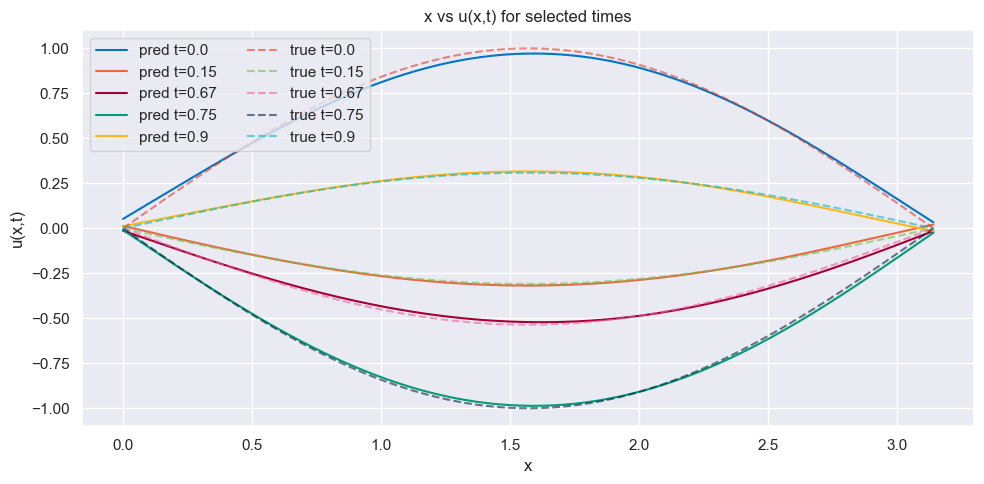

In [36]:
# Plot x vs u(x,t) for multiple time instants using the trained model

def plot_x_vs_u_at_times(model, times=(0.0, 0.15, 0.67, 0.75, 0.9), Nx=200, L_val=None, with_exact=True):
    L_local = float(L_val if L_val is not None else L)
    x = torch.linspace(0.0, L_local, Nx).view(-1, 1).to(device)
    curves = []
    with torch.no_grad():
        for t_val in times:
            t = torch.full_like(x, float(t_val)).to(device)
            x_norm = x_normalizer.normalize(x)
            t_norm = t_normalizer.normalize(t)
            u_pred_output_norm = model(torch.cat([x_norm, t_norm], dim=1))
            u_pred_output_denorm = u_normalizer.denormalize(u_pred_output_norm)
            curves.append((t_val, x.squeeze().cpu(), u_pred_output_denorm.squeeze().cpu()))

    plt.figure(figsize=(10,5))
    for t_val, x_cpu, u_cpu in curves:
        plt.plot(x_cpu.numpy(), u_cpu.numpy(), label=f"pred t={t_val}")

    # Optional exact solution overlay if u(x,t) is defined above
    if with_exact and 'u' in globals():
        for t_val in times:
            x_t = torch.linspace(0.0, L_local, Nx).view(-1,1).to(device)
            t_t = torch.full_like(x_t, float(t_val)).to(device)
            u_true = u_exact(x_t, t_t).detach().cpu().squeeze()
            plt.plot(x_t.squeeze().cpu().numpy(), u_true.numpy(), '--', alpha=0.6, label=f"true t={t_val}")

    plt.xlabel('x')
    plt.ylabel('u(x,t)')
    plt.title('x vs u(x,t) for selected times')
    plt.legend(ncol=2)
    plt.tight_layout()
    plt.show()

# Run the plot
plot_x_vs_u_at_times(pinn, times=(0.0, 0.15, 0.67, 0.75, 0.9), Nx=300, L_val=L, with_exact=True)

In [37]:
Nx, Nt = 200, 200
xv = np.linspace(0, np.pi, Nx)
tv = np.linspace(0, 1, Nt)
X, T = np.meshgrid(xv, tv, indexing="ij")          # X,T shape: (Nx, Nt)

xg = torch.tensor(X.reshape(-1, 1), dtype=torch.float32, device=device)
tg = torch.tensor(T.reshape(-1, 1), dtype=torch.float32, device=device)

xg_n = x_normalizer.normalize(xg)
tg_n = t_normalizer.normalize(tg)

with torch.no_grad():
    u_n = pinn(torch.cat([xg_n, tg_n], dim=1))

u_pred = u_normalizer.denormalize(u_n).cpu().numpy().reshape(Nx, Nt)
u_true = u_exact(xg, tg).cpu().numpy().reshape(Nx, Nt)
R_u = np.linalg.norm(u_pred - u_true) / np.linalg.norm(u_true) * 100

print(f"Grid relative error (u):     {R_u:.6f}%")

Grid relative error (u):     2.215682%


In the following cells, the velocity, acceleration and bending moment are obtained from the beam deflection and comparted to the analytical solutions.

In [38]:
def get_model_prediction(model, x_array, t_array, x_normalizer, t_normalizer):
    """
    Compute u(x,t) from model for all x and t.

    Returns:
        u_pred: torch.Tensor of shape [Nt, Nx]
    """
    Nx = len(x_array)
    Nt = len(t_array)

    Xg, Tg = np.meshgrid(x_array, t_array, indexing="xy")
    x_flat = Xg.ravel()
    t_flat = Tg.ravel()

    x_tensor = torch.tensor(x_flat, dtype=torch.float32)
    t_tensor = torch.tensor(t_flat, dtype=torch.float32, requires_grad=True)
    bias_tensor = torch.ones_like(x_tensor)

    # Normalize
    x_norm = x_normalizer.normalize(x_tensor)
    t_norm = t_normalizer.normalize(t_tensor)

    inputs = torch.stack([x_norm, t_norm, bias_tensor], dim=1)

    u_pred = model(inputs)[:, 1]  # u channel
    u_pred = u_pred.view(Nt, Nx)  # reshape [Nt, Nx]

    return u_pred, t_tensor, x_tensor

In [39]:
#Velocity (first derivative of deflection with respect to time)
def velocity_exact(x,t):
  return - 4*np.pi* torch.sin(x) * torch.sin(4 * np.pi * t)

def compute_velocity(u_pred, t_tensor_with_grad): #Compute du/dt
    velo = torch.autograd.grad(
        outputs=u_pred,
        inputs=t_tensor_with_grad,
        grad_outputs=torch.ones_like(u_pred),
        create_graph=True,
        retain_graph=True
    )[0]
    return velo

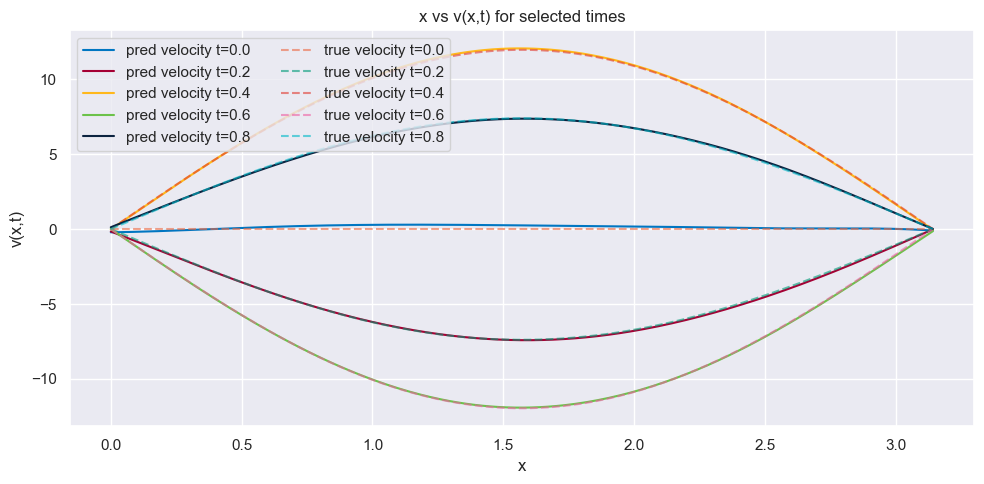

In [40]:
# Plot x vs u(x,t) for multiple time instants using the trained model

def plot_x_vs_velocity(model, times=(0.0, 0.15, 0.67, 0.75, 0.9), Nx=200, L_val=None, with_exact=True):
    L_local = float(L_val if L_val is not None else L)

    fig, ax = plt.subplots(figsize=(10,5))

    pred_handles = []
    pred_labels = []
    true_handles = []
    true_labels = []

    for t_val in times:
        # x values for plotting
        x_plot = torch.linspace(0.0, L_local, Nx).view(-1, 1).to(device)
        # t values for plotting
        t_plot = torch.full_like(x_plot, float(t_val)).to(device)

        # Prepare inputs for model and gradient calculation
        x_tensor_for_grad = x_plot.clone().detach().requires_grad_(True)
        t_tensor_for_grad = t_plot.clone().detach().requires_grad_(True)

        # Normalize inputs for the PINN model
        x_norm = x_normalizer.normalize(x_tensor_for_grad)
        t_norm = t_normalizer.normalize(t_tensor_for_grad)

        # Get u prediction from PINN
        u_pred_output_norm = model(torch.cat([x_norm, t_norm], dim=1))
        u_pred_output_denorm = u_normalizer.denormalize(u_pred_output_norm)

        # Compute predicted velocity
        predicted_velocity = compute_velocity(u_pred_output_denorm, t_tensor_for_grad)

        # Plot predicted velocity
        pred_line, = ax.plot(x_plot.squeeze().cpu().numpy(), predicted_velocity.squeeze().cpu().detach().numpy(), label=f"pred velocity t={t_val}")
        pred_handles.append(pred_line)
        pred_labels.append(f"pred velocity t={t_val}")

        # exact solution overlay
        if with_exact and 'velocity_exact' in globals():
            true_velocity = velocity_exact(x_plot, t_plot).detach().cpu().squeeze()
            true_line, = ax.plot(x_plot.squeeze().cpu().numpy(), true_velocity.numpy(), '--', alpha=0.6, label=f"true velocity t={t_val}")
            true_handles.append(true_line)
            true_labels.append(f"true velocity t={t_val}")

    # Arrange handles and labels for a two-column legend: Column 1: all predictions, Column 2: all true values
    final_handles = pred_handles + true_handles
    final_labels = pred_labels + true_labels

    ax.set_xlabel('x')
    ax.set_ylabel('v(x,t)')
    ax.set_title('x vs v(x,t) for selected times')
    ax.legend(final_handles, final_labels, ncol=2)
    plt.tight_layout()
    plt.show()

# plot the velocities
plot_x_vs_velocity(pinn, times=(0.0, 0.2, 0.4, 0.6, 0.8), Nx=300, L_val=L, with_exact=True)

In [41]:
#Acceleration (second derivative of deflection with respect to time)
def acceleration_exact(x,t):
  return - 14*np.pi**2 * torch.sin(x) * torch.cos(4 * np.pi * t)

def compute_acceleration(u_pred, t_tensor_with_grad): #Compute d^2u/dt^2
    # First derivative
    du_dt = torch.autograd.grad(
        outputs=u_pred,
        inputs=t_tensor_with_grad,
        grad_outputs=torch.ones_like(u_pred),
        create_graph=True,
        retain_graph=True
    )[0]

    # Second derivative
    d2u_dt2 = torch.autograd.grad(
        outputs=du_dt,
        inputs=t_tensor_with_grad,
        grad_outputs=torch.ones_like(du_dt),
        create_graph=True,
        retain_graph=True
    )[0]

    return d2u_dt2

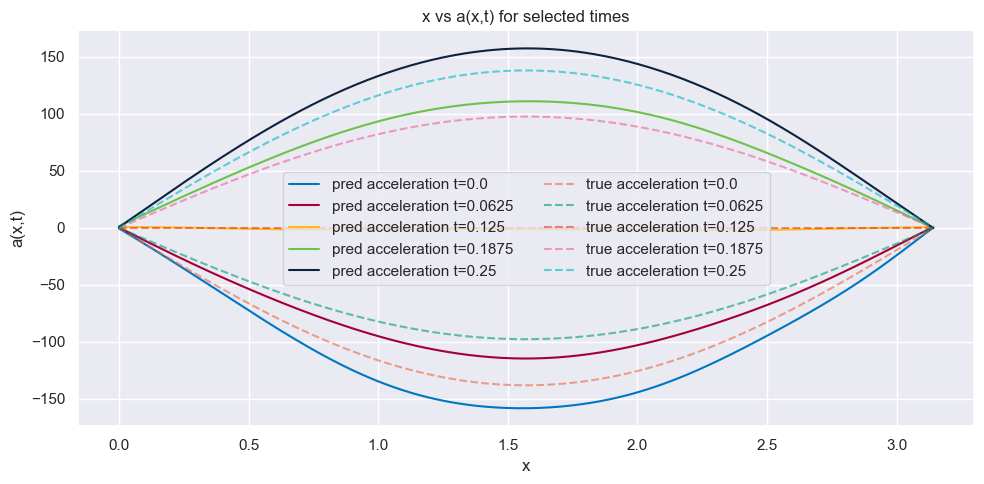

In [42]:
# Plot x vs a(x,t) for multiple time instants using the trained model

def plot_x_vs_acceleration(model, times=(0.0, 0.15, 0.67, 0.75, 0.9), Nx=200, L_val=None, with_exact=True):
    L_local = float(L_val if L_val is not None else L)

    fig, ax = plt.subplots(figsize=(10,5))

    pred_handles = []
    pred_labels = []
    true_handles = []
    true_labels = []

    for t_val in times:
        # x values for plotting
        x_plot = torch.linspace(0.0, L_local, Nx).view(-1, 1).to(device)
        # t values for plotting
        t_plot = torch.full_like(x_plot, float(t_val)).to(device)

        # Prepare inputs for model and gradient calculation
        x_tensor_for_grad = x_plot.clone().detach().requires_grad_(True)
        t_tensor_for_grad = t_plot.clone().detach().requires_grad_(True)

        # Normalize inputs for the PINN model
        x_norm = x_normalizer.normalize(x_tensor_for_grad)
        t_norm = t_normalizer.normalize(t_tensor_for_grad)

        # Get u prediction from PINN
        u_pred_output_norm = model(torch.cat([x_norm, t_norm], dim=1))
        u_pred_output_denorm = u_normalizer.denormalize(u_pred_output_norm)

        # Compute predicted acceleration
        predicted_acceleration = compute_acceleration(u_pred_output_denorm, t_tensor_for_grad)

        # Plot predicted acceleration
        pred_line, = ax.plot(x_plot.squeeze().cpu().numpy(), predicted_acceleration.squeeze().cpu().detach().numpy(), label=f"pred acceleration t={t_val}")
        pred_handles.append(pred_line)
        pred_labels.append(f"pred acceleration t={t_val}")

        # exact solution overlay
        if with_exact and 'acceleration_exact' in globals():
            true_acceleration = acceleration_exact(x_plot, t_plot).detach().cpu().squeeze()
            true_line, = ax.plot(x_plot.squeeze().cpu().numpy(), true_acceleration.numpy(), '--', alpha=0.6, label=f"true acceleration t={t_val}")
            true_handles.append(true_line)
            true_labels.append(f"true acceleration t={t_val}")

    # Arrange handles and labels for a two-column legend: Column 1: all predictions, Column 2: all true values
    final_handles = pred_handles + true_handles
    final_labels = pred_labels + true_labels

    ax.set_xlabel('x')
    ax.set_ylabel('a(x,t)')
    ax.set_title('x vs a(x,t) for selected times')
    ax.legend(final_handles, final_labels, ncol=2)
    plt.tight_layout()
    plt.show()

# plot the accelerations
plot_x_vs_acceleration(pinn, times=(0.0, 0.0625, 0.125, 0.1875, 0.25), Nx=300, L_val=L, with_exact=True)

In [43]:
#Bending moment (second derivative of deflection with respect to space multiplied with EI)
#M = -EI * d^2u/dx^2

def bending_moment_exact(x,t):
  return EI * torch.sin(x) * torch.cos(4 * np.pi * t)

def compute_bending_moment(u_pred, x_tensor_with_grad, EI):
    # First derivative wrt x
    du_dx = torch.autograd.grad(
        outputs=u_pred,
        inputs=x_tensor_with_grad,
        grad_outputs=torch.ones_like(u_pred),
        create_graph=True,
        retain_graph=True
    )[0]

    # Second derivative wrt x
    d2u_dx2 = torch.autograd.grad(
        outputs=du_dx,
        inputs=x_tensor_with_grad,
        grad_outputs=torch.ones_like(du_dx),
        create_graph=True,
        retain_graph=True
    )[0]

    M = -EI * d2u_dx2
    return M

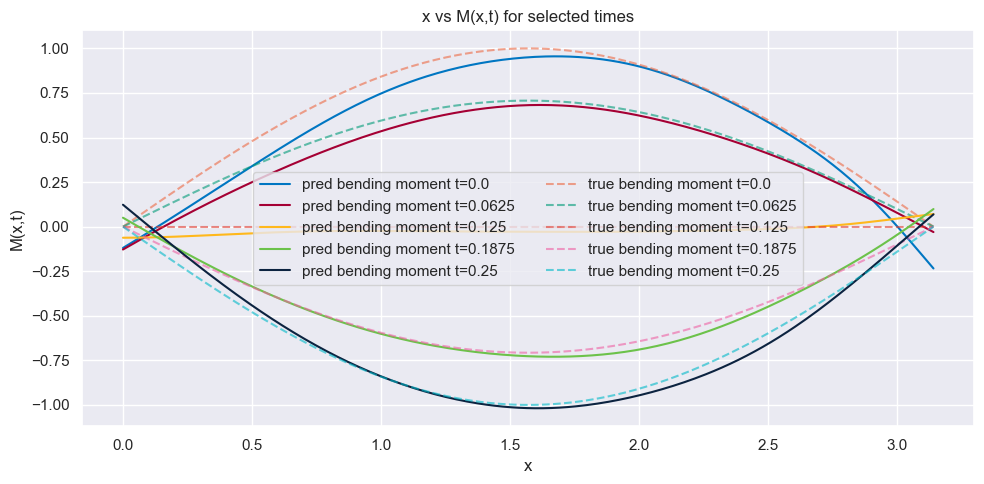

In [44]:
# Plot x vs M(x,t) for multiple time instants using the trained model

def plot_x_vs_bending_moment(model, times=(0.0, 0.15, 0.67, 0.75, 0.9), Nx=200, L_val=None, with_exact=True):
    L_local = float(L_val if L_val is not None else L)

    fig, ax = plt.subplots(figsize=(10,5))

    pred_handles = []
    pred_labels = []
    true_handles = []
    true_labels = []

    for t_val in times:
        # x values for plotting
        x_plot = torch.linspace(0.0, L_local, Nx).view(-1, 1).to(device)
        # t values for plotting
        t_plot = torch.full_like(x_plot, float(t_val)).to(device)

        # Prepare inputs for model and gradient calculation
        x_tensor_for_grad = x_plot.clone().detach().requires_grad_(True)
        t_tensor_for_grad = t_plot.clone().detach().requires_grad_(True)

        # Normalize inputs for the PINN model
        x_norm = x_normalizer.normalize(x_tensor_for_grad)
        t_norm = t_normalizer.normalize(t_tensor_for_grad)

        # Get u prediction from PINN
        u_pred_output_norm = model(torch.cat([x_norm, t_norm], dim=1))
        u_pred_output_denorm = u_normalizer.denormalize(u_pred_output_norm)

        # Compute predicted bending moment
        predicted_bending_moment = compute_bending_moment(u_pred_output_denorm, x_tensor_for_grad, 1)

        # Plot predicted bending moment
        pred_line, = ax.plot(x_plot.squeeze().cpu().numpy(), predicted_bending_moment.squeeze().cpu().detach().numpy(), label=f"pred bending moment t={t_val}")
        pred_handles.append(pred_line)
        pred_labels.append(f"pred bending moment t={t_val}")

        # exact solution overlay
        if with_exact and 'bending_moment_exact' in globals():
            true_bending_moment = bending_moment_exact(x_plot, t_plot).detach().cpu().squeeze()
            true_line, = ax.plot(x_plot.squeeze().cpu().numpy(), true_bending_moment.numpy(), '--', alpha=0.6, label=f"true bending moment t={t_val}")
            true_handles.append(true_line)
            true_labels.append(f"true bending moment t={t_val}")

    # Arrange handles and labels for a two-column legend: Column 1: all predictions, Column 2: all true values
    final_handles = pred_handles + true_handles
    final_labels = pred_labels + true_labels

    ax.set_xlabel('x')
    ax.set_ylabel('M(x,t)')
    ax.set_title('x vs M(x,t) for selected times')
    ax.legend(final_handles, final_labels, ncol=2)
    plt.tight_layout()
    plt.show()

# plot the bending moments
plot_x_vs_bending_moment(pinn, times=(0.0, 0.0625, 0.125, 0.1875, 0.25), Nx=300, L_val=L, with_exact=True)

In [45]:
import numpy as np
import torch

Nx, Nt = 200, 200
xv = np.linspace(0, np.pi, Nx)
tv = np.linspace(0, 1, Nt)
X, T = np.meshgrid(xv, tv, indexing="ij")          # X,T shape: (Nx, Nt)

xg = torch.tensor(X.reshape(-1, 1), dtype=torch.float32, device=device, requires_grad=True)
tg = torch.tensor(T.reshape(-1, 1), dtype=torch.float32, device=device, requires_grad=True)

xg_n = x_normalizer.normalize(xg)
tg_n = t_normalizer.normalize(tg)

u_n = pinn(torch.cat([xg_n, tg_n], dim=1))
u_denorm_tensor = u_normalizer.denormalize(u_n)
u_pred_numpy = u_denorm_tensor.detach().cpu().numpy().reshape(Nx, Nt)
u_true_numpy = u_exact(xg, tg).detach().cpu().numpy().reshape(Nx, Nt)

# Compute velocity, acceleration and bending moment, passing the denormalized u tensor and xg for bending moment
v_pred_tensor = compute_velocity(u_denorm_tensor, tg)
a_pred_tensor = compute_acceleration(u_denorm_tensor, tg)
M_pred_tensor = compute_bending_moment(u_denorm_tensor, xg, 1)

v_pred_numpy = v_pred_tensor.detach().cpu().numpy().reshape(Nx, Nt)
a_pred_numpy = a_pred_tensor.detach().cpu().numpy().reshape(Nx, Nt)
M_pred_numpy = M_pred_tensor.detach().cpu().numpy().reshape(Nx, Nt)

v_true_numpy = velocity_exact(xg, tg).detach().cpu().numpy().reshape(Nx, Nt)
a_true_numpy = acceleration_exact(xg, tg).detach().cpu().numpy().reshape(Nx, Nt)
M_true_numpy = bending_moment_exact(xg, tg).detach().cpu().numpy().reshape(Nx, Nt)

R_u = np.linalg.norm(u_pred_numpy - u_true_numpy) / np.linalg.norm(u_true_numpy) * 100
R_v = np.linalg.norm(v_pred_numpy - v_true_numpy) / np.linalg.norm(v_true_numpy) * 100
R_a = np.linalg.norm(a_pred_numpy - a_true_numpy) / np.linalg.norm(a_true_numpy) * 100
R_M = np.linalg.norm(M_pred_numpy - M_true_numpy) / np.linalg.norm(M_true_numpy) * 100

print(f"Grid relative error (u):     {R_u:.6f}%")
print(f"Grid relative error (v):     {R_v:.6f}%")
print(f"Grid relative error (a):     {R_a:.6f}%")
print(f"Grid relative error (M):     {R_M:.6f}%")

Grid relative error (u):     2.215682%
Grid relative error (v):     1.219840%
Grid relative error (a):     14.685182%
Grid relative error (M):     11.556253%


In [31]:
#Animation function
def animate_u_over_time(x, t_list, pred_multi, u_normalizer, u_func, colors, interval=5000):
    """
    Create an animation of exact vs model-predicted u(x,t) over time.

    Args:
        x (np.ndarray): 1D array of x positions, shape [Nx].
        t_list (np.ndarray): 1D array of times, shape [Nt].
        pred_multi (np.ndarray): Predicted outputs, shape [Nt, Nx, C], u in channel 1.
        u_normalizer: normalizer with .denormalize(tensor) for u.
        u_func (callable): exact solution u(x,t).
        colors (list): color list (exact, prediction).
        interval (int): milliseconds between frames.

    Returns:
        ani (FuncAnimation): the animation object.
    """


    from matplotlib.animation import FuncAnimation

    Nt, Nx, C = pred_multi.shape
    assert C >= 2, "Expected u in channel 1."

    # --- Denormalize predictions ---
    u_pred_norm = pred_multi[:, :, 1]                         # shape [Nt, Nx]
    u_pred = u_normalizer.denormalize(
        torch.tensor(u_pred_norm, dtype=torch.float32)
    ).numpy()                                                # shape [Nt, Nx]

    # --- Setup figure ---
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.set_xlabel("x")
    ax.set_ylabel("u(x,t)")
    ax.grid(alpha=0.3)
    ax.set_ylim(-1.5, 1.5)
    # Initial lines
    exact_line, = ax.plot(x, u_func(x, t_list[0]),
                          label="Exact u", color=colors[0])
    pred_line,  = ax.plot(x, u_pred[0],
                          label="NN u", linestyle="--", color=colors[1])

    ax.legend()
    ax.set_title(f"t = {t_list[0]:.3f}")

    # --- Update function ---
    def update(frame):
        exact_line.set_ydata(u_func(x, t_list[frame]))
        pred_line.set_ydata(u_pred[frame])
        ax.set_title(f"t = {t_list[frame]:.3f}")
        return exact_line, pred_line

    # --- Build animation ---
    ani = FuncAnimation(fig, update, frames=len(t_list), interval=interval)
    plt.close(fig)  # prevents duplicate static figure in notebooks

    return ani